## Demand Forecasting Pipeline
<b> Day 1: Setting up basics for forecasting pipeline

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

c:\Users\Nourhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    # Filter out zero actual values to avoid division by zero
    mask = actual != 0
    actual, pred = actual[mask], pred[mask]
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data


In [5]:
df = pd.read_csv('quik_data_all.csv')
df.columns = df.columns.str.lower()
df['order_received_timestamp'] = pd.to_datetime(df['order_received_timestamp'], errors='coerce')


In [6]:
min(df['order_received_timestamp']), max(df['order_received_timestamp'])

(Timestamp('2023-12-01 00:00:00'), Timestamp('2024-02-29 23:40:00'))

In [7]:
df.head()

,merchant_id,order_received_timestamp,order_count
0,merchant_1,2023-12-01 00:00:00,1
1,merchant_1,2023-12-01 00:20:00,2
2,merchant_1,2023-12-01 00:40:00,3
3,merchant_1,2023-12-01 01:00:00,2
4,merchant_1,2023-12-01 01:20:00,3


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [8]:
agg_df = df.groupby(['order_received_timestamp', 'merchant_id']).agg({'order_count': 'sum'}).reset_index().sort_values(['merchant_id', 'order_received_timestamp']) #groups the data frame
#(where segment corresponds to merchant, timestamp to date, and target to orders


In [9]:
agg_df.head()

,order_received_timestamp,merchant_id,order_count
0,2023-12-01 00:00:00,merchant_1,1
7,2023-12-01 00:20:00,merchant_1,2
15,2023-12-01 00:40:00,merchant_1,3
24,2023-12-01 01:00:00,merchant_1,2
33,2023-12-01 01:20:00,merchant_1,3


In [10]:
agg_df.tail()

,order_received_timestamp,merchant_id,order_count
70659,2024-02-29 22:20:00,merchant_9,1
70671,2024-02-29 22:40:00,merchant_9,1
70682,2024-02-29 23:00:00,merchant_9,2
70691,2024-02-29 23:20:00,merchant_9,0
70699,2024-02-29 23:40:00,merchant_9,2


In [11]:
total_orders_df = agg_df.pivot(index='order_received_timestamp', columns='merchant_id', values='order_count')
total_orders_df.tail()

merchant_id,merchant_1,merchant_10,merchant_11,merchant_12,merchant_2,merchant_3,merchant_4,merchant_5,merchant_6,merchant_7,merchant_8,merchant_9
order_received_timestamp,,,,,,,,,,,,
2024-02-29 22:20:00,3.00,4.00,0.00,1.00,0.00,1.00,1.00,2.00,1.00,4.00,5.00,1.00
2024-02-29 22:40:00,1.00,5.00,2.00,0.00,2.00,1.00,4.00,1.00,2.00,3.00,1.00,1.00
2024-02-29 23:00:00,1.00,3.00,1.00,1.00,2.00,3.00,3.00,2.00,1.00,NaN,1.00,2.00
2024-02-29 23:20:00,1.00,2.00,0.00,NaN,4.00,1.00,2.00,0.00,NaN,NaN,3.00,0.00
2024-02-29 23:40:00,2.00,3.00,1.00,NaN,1.00,1.00,NaN,1.00,NaN,NaN,1.00,2.00


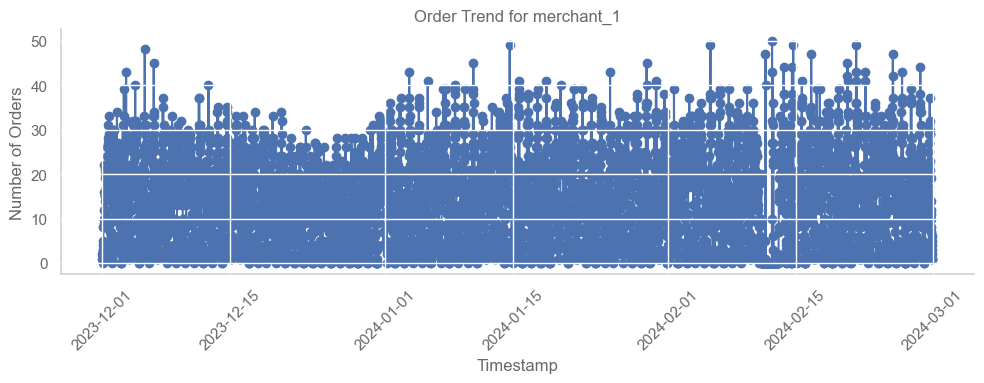

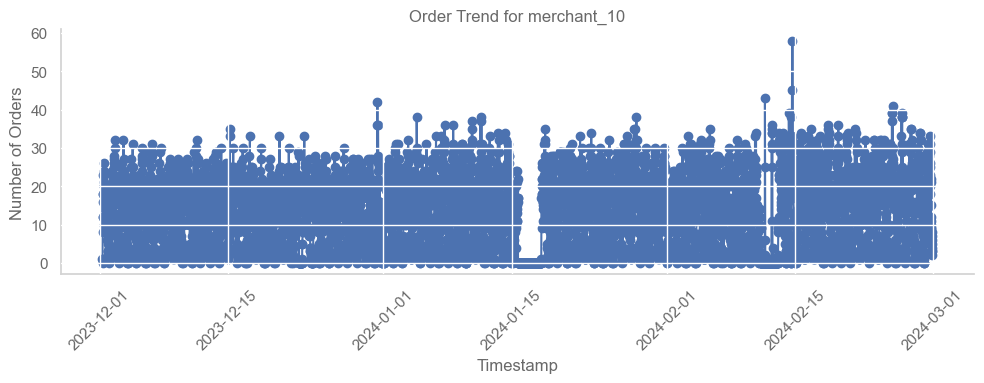

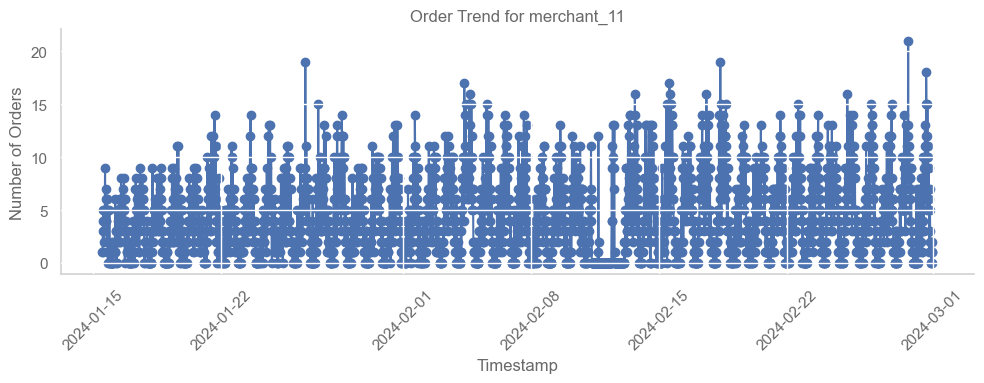

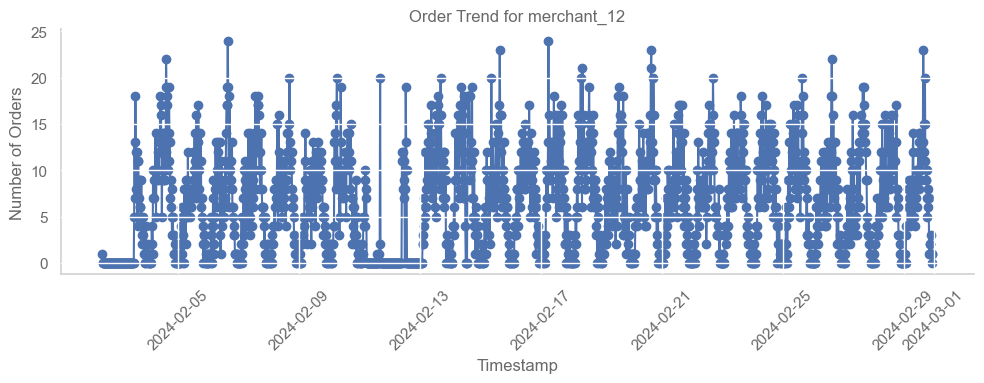

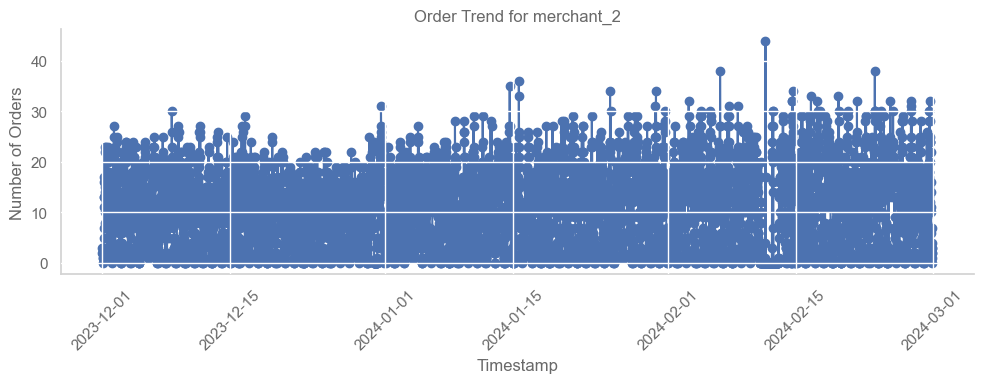

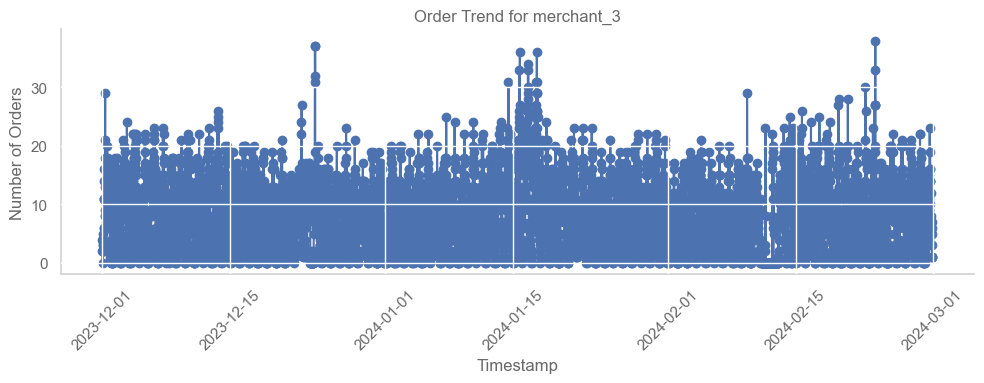

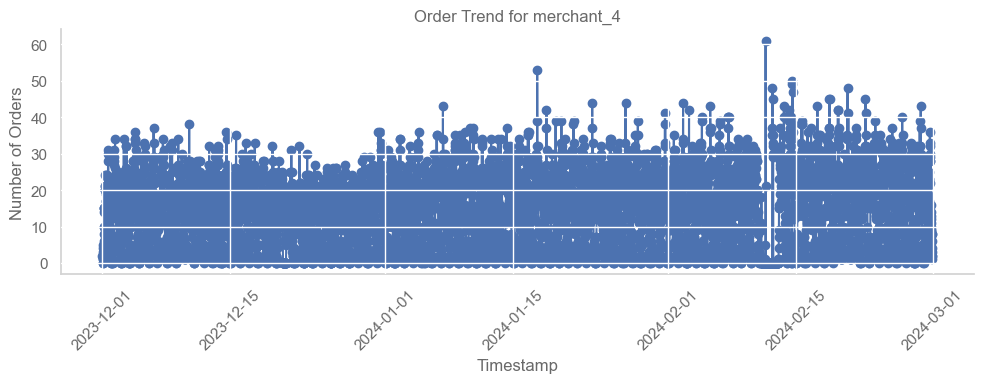

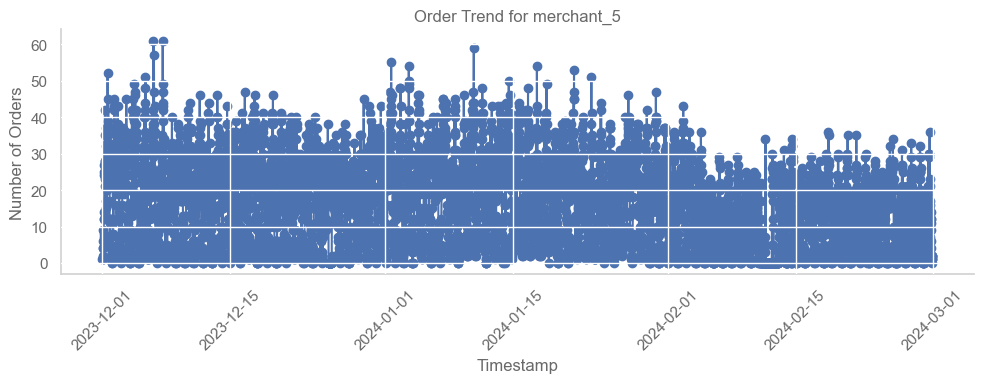

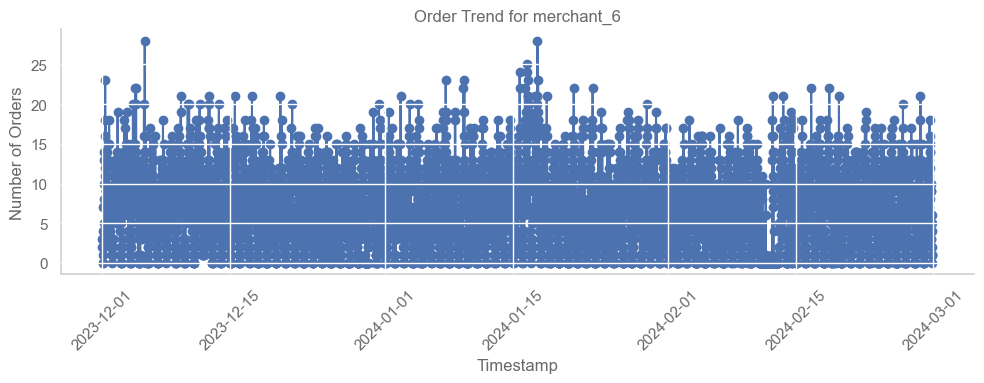

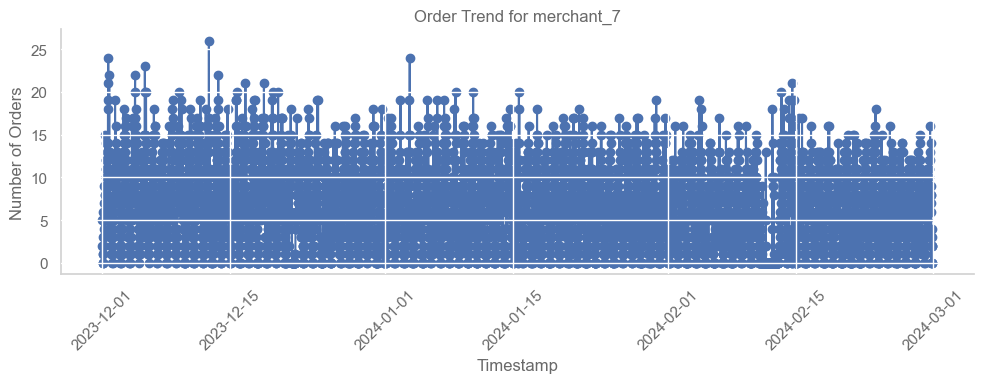

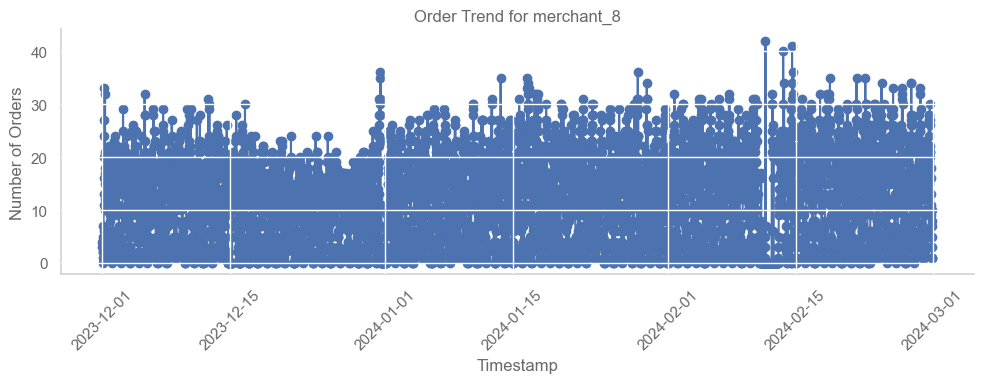

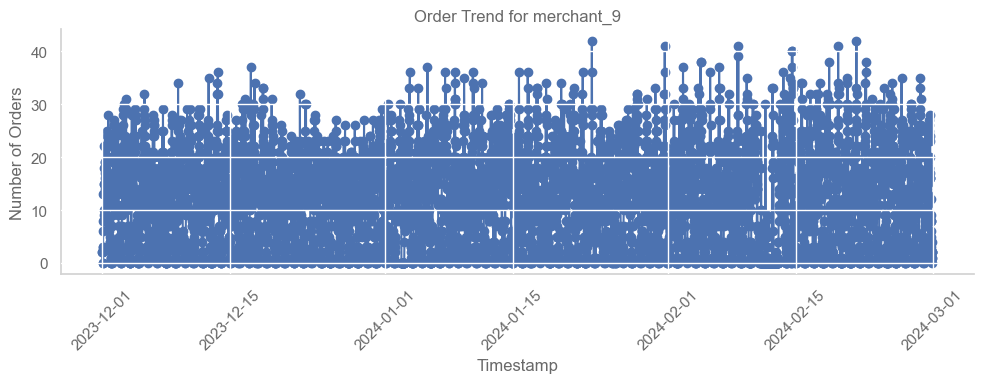

In [12]:
for column in total_orders_df.columns:
    plt.figure(figsize=(10, 4))  
    plt.plot(total_orders_df.index, total_orders_df[column], marker='o', linestyle='-')  
    plt.title(f"Order Trend for {column}")
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Orders')
    plt.grid(True)  
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

In [13]:
total_orders_df = total_orders_df[total_orders_df.index >= '2023-12-01']


In [14]:
missing_data(total_orders_df)

,Total,Percent,Types
merchant_id,,,
merchant_1,25,0.38,float64
merchant_10,23,0.35,float64
merchant_11,3285,50.14,float64
merchant_12,4573,69.80,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,4,0.06,float64
merchant_5,0,0.00,float64
merchant_6,3,0.05,float64


In [15]:
total_orders_df.fillna(0, inplace=True) #filling nan values with zeros

# or filling NaN values with the mean of each column
#total_orders_df.fillna(total_orders_df.mean(), inplace=True)

missing_data(total_orders_df)

,Total,Percent,Types
merchant_id,,,
merchant_1,0,0.00,float64
merchant_10,0,0.00,float64
merchant_11,0,0.00,float64
merchant_12,0,0.00,float64
merchant_2,0,0.00,float64
merchant_3,0,0.00,float64
merchant_4,0,0.00,float64
merchant_5,0,0.00,float64
merchant_6,0,0.00,float64


DATA CLEANING REQUIREMENTS
Remove low-volume data that can't be predicted.
Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [ ]:
#No Data Cleaning now

#### Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

### Category Grouping

In [16]:
#lets break it down by thirds for low, mid, high
avg_daily_orders = total_orders_df.apply(np.mean, axis=0).sort_values() #typical order volume per merchant across all timestamps.

low, mid = np.percentile(avg_daily_orders, [33, 66]) #thresholds for low, mid, and high order volumes.


In [17]:
# Create lists of merchants based on order volume categories
low_vol_columns = list(avg_daily_orders[avg_daily_orders <= low].index)
mid_vol_columns = list(avg_daily_orders[(avg_daily_orders > low) & (avg_daily_orders < mid)].index)
high_vol_columns = list(avg_daily_orders[avg_daily_orders >= mid].index)



In [18]:
high_vol_columns

['merchant_10', 'merchant_1', 'merchant_4', 'merchant_5']

In [19]:
# plt.figure(figsize=(12, 6))  
# for merchant in low_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Low Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best')  
# plt.grid(True)  
# plt.xticks(rotation=45)  
# plt.tight_layout() 
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 6)) 
# for merchant in mid_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for Mid Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Positioning the legend outside the plot area
# plt.grid(True)  # Adding a grid for better readability
# plt.xticks(rotation=30)  
# plt.tight_layout() 
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 6))  # Set a suitable figure size
# for merchant in high_vol_columns:
#     plt.plot(total_orders_df.index, total_orders_df[merchant], label=merchant)

# plt.title('Order Trends for High Volume Merchants')
# plt.xlabel('Timestamp')
# plt.ylabel('Number of Orders')
# plt.legend(title='Merchant', loc='best', bbox_to_anchor=(1.1, 1.05))  # Properly title the legend and adjust its position
# plt.xticks(rotation=30)
# plt.grid(True)  # Optionally add a grid
# plt.tight_layout()  # Adjust layout
# plt.show()

### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [20]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [21]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [22]:
start_time = time.time()

dicts = {}

for feature in total_orders_df.columns:
  
    category_df = total_orders_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    #mapes = [] 
    rmses = []
    maes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="60 days", period="5 days", horizon = "1 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        #mapes.append(df_p["mape"].values[0])
        rmses.append(df_p["rmse"].values[0])
        maes.append(df_p["mae"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    #tuning_results["mape"] = mapes
    tuning_results["rmse"] = rmses
    tuning_results["mae"] = maes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("rmse").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) 

18:13:13 - cmdstanpy - INFO - Chain [1] start processing
18:13:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.72it/s]18:13:15 - cmdstanpy - INFO - Chain [1] start processing
18:13:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.70it/s]18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.75it/s]18:13:16 - cmdstanpy - INFO - Chain [1] start processing
18:13:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.69it/s]18:13:17 - cmdstanpy - INFO - Chain [1] start processing
18:13:17 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.44it/s]18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 30.22  5.50 4.04   0.23   0.38      0.82


18:13:19 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:19 - cmdstanpy - INFO - Chain [1] start processing
18:13:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.69it/s]18:13:20 - cmdstanpy - INFO - Chain [1] start processing
18:13:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.75it/s]18:13:21 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.68it/s]18:13:21 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.62it/s]18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.55it/s]18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.65  5.44 3.95   0.22   0.37      0.82


18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.83it/s]18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.66it/s]18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.66it/s]18:13:26 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.61it/s]18:13:27 - cmdstanpy - INFO - Chain [1] start processing
18:13:27 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.47it/s]18:13:27 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.54  5.43 3.95   0.23   0.37      0.82


18:13:28 - cmdstanpy - INFO - Chain [1] start processing
18:13:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.53it/s]18:13:30 - cmdstanpy - INFO - Chain [1] start processing
18:13:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.54it/s]18:13:30 - cmdstanpy - INFO - Chain [1] start processing
18:13:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]18:13:31 - cmdstanpy - INFO - Chain [1] start processing
18:13:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.56it/s]18:13:32 - cmdstanpy - INFO - Chain [1] start processing
18:13:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.50it/s]18:13:32 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.58  5.44 3.95   0.23   0.37      0.82


18:13:33 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.71it/s]18:13:34 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.53it/s]18:13:35 - cmdstanpy - INFO - Chain [1] start processing
18:13:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]18:13:36 - cmdstanpy - INFO - Chain [1] start processing
18:13:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.59it/s]18:13:37 - cmdstanpy - INFO - Chain [1] start processing
18:13:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.48it/s]18:13:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.52  5.43 3.94   0.23   0.37      0.81


18:13:38 - cmdstanpy - INFO - Chain [1] start processing
18:13:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:40 - cmdstanpy - INFO - Chain [1] start processing
18:13:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.00s/it]18:13:41 - cmdstanpy - INFO - Chain [1] start processing
18:13:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.04it/s]18:13:42 - cmdstanpy - INFO - Chain [1] start processing
18:13:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.20it/s]18:13:43 - cmdstanpy - INFO - Chain [1] start processing
18:13:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.12it/s]18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:44 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.00it/s]18:13:45 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.23  5.94 4.46   0.27   0.45      0.77


18:13:46 - cmdstanpy - INFO - Chain [1] start processing
18:13:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:47 - cmdstanpy - INFO - Chain [1] start processing
18:13:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.13it/s]18:13:48 - cmdstanpy - INFO - Chain [1] start processing
18:13:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.12it/s]18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.04it/s]18:13:50 - cmdstanpy - INFO - Chain [1] start processing
18:13:51 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.03it/s]18:13:51 - cmdstanpy - INFO - Chain [1] start processing
18:13:52 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.07s/it]18:13:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.65  5.89 4.41   0.27   0.45      0.76


18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]18:13:56 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.17it/s]18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.03it/s]18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.04it/s]18:13:59 - cmdstanpy - INFO - Chain [1] start processing
18:14:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:01,  1.05s/it]18:14:00 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.69  5.89 4.41   0.27   0.45      0.77


18:14:02 - cmdstanpy - INFO - Chain [1] start processing
18:14:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:14:03 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.09it/s]18:14:04 - cmdstanpy - INFO - Chain [1] start processing
18:14:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.12s/it]18:14:06 - cmdstanpy - INFO - Chain [1] start processing
18:14:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.04s/it]18:14:07 - cmdstanpy - INFO - Chain [1] start processing
18:14:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.04s/it]18:14:08 - cmdstanpy - INFO - Chain [1] start processing
18:14:08 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.11s/it]18:14:09 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.63  5.88 4.41   0.27   0.45      0.76


18:14:10 - cmdstanpy - INFO - Chain [1] start processing
18:14:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:14:12 - cmdstanpy - INFO - Chain [1] start processing
18:14:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.19it/s]18:14:13 - cmdstanpy - INFO - Chain [1] start processing
18:14:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.05it/s]18:14:14 - cmdstanpy - INFO - Chain [1] start processing
18:14:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.05s/it]18:14:15 - cmdstanpy - INFO - Chain [1] start processing
18:14:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.09s/it]18:14:16 - cmdstanpy - INFO - Chain [1] start processing
18:14:17 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.13s/it]18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.74  5.89 4.42   0.27   0.45      0.77


18:14:19 - cmdstanpy - INFO - Chain [1] start processing
18:14:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:14:21 - cmdstanpy - INFO - Chain [1] start processing
18:14:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]18:14:23 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.14s/it]18:14:24 - cmdstanpy - INFO - Chain [1] start processing
18:14:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.12s/it]18:14:25 - cmdstanpy - INFO - Chain [1] start processing
18:14:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.10s/it]18:14:26 - cmdstanpy - INFO - Chain [1] start processing
18:14:27 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.42s/it]18:14:28 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.85  5.99 4.52   0.28   0.46      0.75


18:14:29 - cmdstanpy - INFO - Chain [1] start processing
18:14:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:14:31 - cmdstanpy - INFO - Chain [1] start processing
18:14:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.04it/s]18:14:32 - cmdstanpy - INFO - Chain [1] start processing
18:14:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.02it/s]18:14:33 - cmdstanpy - INFO - Chain [1] start processing
18:14:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.01s/it]18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.05s/it]18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.26s/it]18:14:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.31  5.94 4.48   0.27   0.46      0.76


18:14:39 - cmdstanpy - INFO - Chain [1] start processing
18:14:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:14:40 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]18:14:42 - cmdstanpy - INFO - Chain [1] start processing
18:14:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.15s/it]18:14:43 - cmdstanpy - INFO - Chain [1] start processing
18:14:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.23s/it]18:14:44 - cmdstanpy - INFO - Chain [1] start processing
18:14:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.14s/it]18:14:45 - cmdstanpy - INFO - Chain [1] start processing
18:14:46 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.28s/it]18:14:47 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.33  5.94 4.48   0.27   0.46      0.77


18:14:49 - cmdstanpy - INFO - Chain [1] start processing
18:14:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:14:51 - cmdstanpy - INFO - Chain [1] start processing
18:14:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.15s/it]18:14:52 - cmdstanpy - INFO - Chain [1] start processing
18:14:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.22s/it]18:14:53 - cmdstanpy - INFO - Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.39s/it]18:14:55 - cmdstanpy - INFO - Chain [1] start processing
18:14:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.42s/it]18:14:56 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.66s/it]18:14:58 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.35  5.95 4.48   0.27   0.46      0.77


18:15:00 - cmdstanpy - INFO - Chain [1] start processing
18:15:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:15:02 - cmdstanpy - INFO - Chain [1] start processing
18:15:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.28s/it]18:15:03 - cmdstanpy - INFO - Chain [1] start processing
18:15:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.31s/it]18:15:04 - cmdstanpy - INFO - Chain [1] start processing
18:15:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.35s/it]18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.32s/it]18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.52s/it]18:15:09 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.35  5.95 4.48   0.27   0.46      0.76


18:15:11 - cmdstanpy - INFO - Chain [1] start processing
18:15:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:15:12 - cmdstanpy - INFO - Chain [1] start processing
18:15:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]18:15:13 - cmdstanpy - INFO - Chain [1] start processing
18:15:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.14s/it]18:15:15 - cmdstanpy - INFO - Chain [1] start processing
18:15:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.15s/it]18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.29s/it]18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.54s/it]18:15:19 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.22  6.02 4.56   0.28   0.46      0.76


18:15:21 - cmdstanpy - INFO - Chain [1] start processing
18:15:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:15:23 - cmdstanpy - INFO - Chain [1] start processing
18:15:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]18:15:24 - cmdstanpy - INFO - Chain [1] start processing
18:15:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.18s/it]18:15:25 - cmdstanpy - INFO - Chain [1] start processing
18:15:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.17s/it]18:15:27 - cmdstanpy - INFO - Chain [1] start processing
18:15:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.35s/it]18:15:28 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.64s/it]18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.61  5.97 4.51   0.27   0.46      0.75


18:15:33 - cmdstanpy - INFO - Chain [1] start processing
18:15:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:15:34 - cmdstanpy - INFO - Chain [1] start processing
18:15:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.31s/it]18:15:36 - cmdstanpy - INFO - Chain [1] start processing
18:15:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.28s/it]18:15:37 - cmdstanpy - INFO - Chain [1] start processing
18:15:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.24s/it]18:15:38 - cmdstanpy - INFO - Chain [1] start processing
18:15:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.20s/it]18:15:39 - cmdstanpy - INFO - Chain [1] start processing
18:15:41 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.54s/it]18:15:41 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.60  5.97 4.51   0.27   0.46      0.75


18:15:43 - cmdstanpy - INFO - Chain [1] start processing
18:15:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:15:46 - cmdstanpy - INFO - Chain [1] start processing
18:15:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]18:15:47 - cmdstanpy - INFO - Chain [1] start processing
18:15:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]18:15:48 - cmdstanpy - INFO - Chain [1] start processing
18:15:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.23s/it]18:15:49 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.17s/it]18:15:50 - cmdstanpy - INFO - Chain [1] start processing
18:15:52 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.44s/it]18:15:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.62  5.97 4.51   0.27   0.46      0.76


18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:15:56 - cmdstanpy - INFO - Chain [1] start processing
18:15:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.41s/it]18:15:57 - cmdstanpy - INFO - Chain [1] start processing
18:15:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.25s/it]18:15:58 - cmdstanpy - INFO - Chain [1] start processing
18:15:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.31s/it]18:16:00 - cmdstanpy - INFO - Chain [1] start processing
18:16:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]18:16:01 - cmdstanpy - INFO - Chain [1] start processing
18:16:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.46s/it]18:16:03 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.70  5.98 4.51   0.27   0.47      0.77


18:16:05 - cmdstanpy - INFO - Chain [1] start processing
18:16:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:16:07 - cmdstanpy - INFO - Chain [1] start processing
18:16:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.37s/it]18:16:08 - cmdstanpy - INFO - Chain [1] start processing
18:16:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.43s/it]18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.52s/it]18:16:11 - cmdstanpy - INFO - Chain [1] start processing
18:16:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.63s/it]18:16:13 - cmdstanpy - INFO - Chain [1] start processing
18:16:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.63s/it]18:16:15 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.34  6.03 4.57   0.28   0.47      0.75


18:16:17 - cmdstanpy - INFO - Chain [1] start processing
18:16:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:16:18 - cmdstanpy - INFO - Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.21s/it]18:16:20 - cmdstanpy - INFO - Chain [1] start processing
18:16:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.09s/it]18:16:21 - cmdstanpy - INFO - Chain [1] start processing
18:16:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.18s/it]18:16:22 - cmdstanpy - INFO - Chain [1] start processing
18:16:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.34s/it]18:16:24 - cmdstanpy - INFO - Chain [1] start processing
18:16:25 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.62s/it]18:16:26 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.80  5.98 4.53   0.27   0.47      0.75


18:16:28 - cmdstanpy - INFO - Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:16:30 - cmdstanpy - INFO - Chain [1] start processing
18:16:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.32s/it]18:16:31 - cmdstanpy - INFO - Chain [1] start processing
18:16:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:06,  1.53s/it]18:16:33 - cmdstanpy - INFO - Chain [1] start processing
18:16:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.55s/it]18:16:34 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.71s/it]18:16:36 - cmdstanpy - INFO - Chain [1] start processing
18:16:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.72s/it]18:16:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.84  5.99 4.53   0.27   0.47      0.76


18:16:40 - cmdstanpy - INFO - Chain [1] start processing
18:16:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:16:42 - cmdstanpy - INFO - Chain [1] start processing
18:16:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.25s/it]18:16:43 - cmdstanpy - INFO - Chain [1] start processing
18:16:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.36s/it]18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.38s/it]18:16:46 - cmdstanpy - INFO - Chain [1] start processing
18:16:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.42s/it]18:16:48 - cmdstanpy - INFO - Chain [1] start processing
18:16:49 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.68s/it]18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.78  5.98 4.52   0.27   0.47      0.75


18:16:52 - cmdstanpy - INFO - Chain [1] start processing
18:16:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:16:55 - cmdstanpy - INFO - Chain [1] start processing
18:16:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.15s/it]18:16:56 - cmdstanpy - INFO - Chain [1] start processing
18:16:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.26s/it]18:16:57 - cmdstanpy - INFO - Chain [1] start processing
18:16:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.25s/it]18:16:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.42s/it]18:17:00 - cmdstanpy - INFO - Chain [1] start processing
18:17:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.65s/it]18:17:02 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.80  5.98 4.53   0.27   0.47      0.76
merchant_1
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  5.50 4.04
1                     0.00                     2.51  5.44 3.95
2                     0.00                     5.00  5.43 3.95
3                     0.00                     7.50  5.44 3.95
4                     0.00                    10.00  5.43 3.94


18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:05 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]18:17:06 - cmdstanpy - INFO - Chain [1] start processing
18:17:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.74it/s]18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.69it/s]18:17:07 - cmdstanpy - INFO - Chain [1] start processing
18:17:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.67it/s]18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:08 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.58it/s]18:17:09 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.60  5.97 4.10   0.24   0.37      0.81


18:17:09 - cmdstanpy - INFO - Chain [1] start processing
18:17:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:10 - cmdstanpy - INFO - Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.83it/s]18:17:11 - cmdstanpy - INFO - Chain [1] start processing
18:17:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.73it/s]18:17:12 - cmdstanpy - INFO - Chain [1] start processing
18:17:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.53it/s]18:17:12 - cmdstanpy - INFO - Chain [1] start processing
18:17:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.40it/s]18:17:13 - cmdstanpy - INFO - Chain [1] start processing
18:17:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]18:17:14 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.40  5.87 4.00   0.24   0.37      0.81


18:17:15 - cmdstanpy - INFO - Chain [1] start processing
18:17:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:15 - cmdstanpy - INFO - Chain [1] start processing
18:17:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.67it/s]18:17:16 - cmdstanpy - INFO - Chain [1] start processing
18:17:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.63it/s]18:17:17 - cmdstanpy - INFO - Chain [1] start processing
18:17:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.66it/s]18:17:17 - cmdstanpy - INFO - Chain [1] start processing
18:17:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.67it/s]18:17:18 - cmdstanpy - INFO - Chain [1] start processing
18:17:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.55it/s]18:17:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.41  5.87 4.00   0.24   0.37      0.81


18:17:19 - cmdstanpy - INFO - Chain [1] start processing
18:17:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:20 - cmdstanpy - INFO - Chain [1] start processing
18:17:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.98it/s]18:17:20 - cmdstanpy - INFO - Chain [1] start processing
18:17:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.64it/s]18:17:21 - cmdstanpy - INFO - Chain [1] start processing
18:17:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.65it/s]18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.63it/s]18:17:22 - cmdstanpy - INFO - Chain [1] start processing
18:17:23 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.51it/s]18:17:23 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.61  5.88 4.01   0.24   0.37      0.81


18:17:24 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:25 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]18:17:26 - cmdstanpy - INFO - Chain [1] start processing
18:17:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.54it/s]18:17:26 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.63it/s]18:17:27 - cmdstanpy - INFO - Chain [1] start processing
18:17:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]18:17:28 - cmdstanpy - INFO - Chain [1] start processing
18:17:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.41it/s]18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.39  5.86 4.00   0.24   0.37      0.81


18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:33 - cmdstanpy - INFO - Chain [1] start processing
18:17:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.61s/it]18:17:34 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.88s/it]18:17:36 - cmdstanpy - INFO - Chain [1] start processing
18:17:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.76s/it]18:17:38 - cmdstanpy - INFO - Chain [1] start processing
18:17:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.85s/it]18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:42 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.96s/it]18:17:42 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.78  6.46 4.59   0.27   0.46      0.77


18:17:44 - cmdstanpy - INFO - Chain [1] start processing
18:17:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:17:46 - cmdstanpy - INFO - Chain [1] start processing
18:17:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]18:17:47 - cmdstanpy - INFO - Chain [1] start processing
18:17:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.59s/it]18:17:49 - cmdstanpy - INFO - Chain [1] start processing
18:17:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.52s/it]18:17:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.84s/it]18:17:53 - cmdstanpy - INFO - Chain [1] start processing
18:17:55 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.94s/it]18:17:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.92  6.40 4.53   0.27   0.46      0.77


18:17:58 - cmdstanpy - INFO - Chain [1] start processing
18:18:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:18:01 - cmdstanpy - INFO - Chain [1] start processing
18:18:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.97s/it]18:18:03 - cmdstanpy - INFO - Chain [1] start processing
18:18:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.80s/it]18:18:04 - cmdstanpy - INFO - Chain [1] start processing
18:18:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:04,  1.61s/it]18:18:06 - cmdstanpy - INFO - Chain [1] start processing
18:18:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.70s/it]18:18:08 - cmdstanpy - INFO - Chain [1] start processing
18:18:09 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.78s/it]18:18:10 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.03  6.41 4.54   0.27   0.46      0.77


18:18:12 - cmdstanpy - INFO - Chain [1] start processing
18:18:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]18:18:14 - cmdstanpy - INFO - Chain [1] start processing
18:18:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.41s/it]18:18:16 - cmdstanpy - INFO - Chain [1] start processing
18:18:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.41s/it]18:18:17 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.75s/it]18:18:20 - cmdstanpy - INFO - Chain [1] start processing
18:18:21 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.83s/it]18:18:22 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.99  6.40 4.54   0.27   0.46      0.78


18:18:24 - cmdstanpy - INFO - Chain [1] start processing
18:18:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:18:26 - cmdstanpy - INFO - Chain [1] start processing
18:18:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.27s/it]18:18:28 - cmdstanpy - INFO - Chain [1] start processing
18:18:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.48s/it]18:18:29 - cmdstanpy - INFO - Chain [1] start processing
18:18:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.50s/it]18:18:31 - cmdstanpy - INFO - Chain [1] start processing
18:18:32 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.71s/it]18:18:33 - cmdstanpy - INFO - Chain [1] start processing
18:18:35 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.02s/it]18:18:35 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.05  6.41 4.54   0.27   0.46      0.78


18:18:38 - cmdstanpy - INFO - Chain [1] start processing
18:18:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:18:41 - cmdstanpy - INFO - Chain [1] start processing
18:18:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.47s/it]18:18:43 - cmdstanpy - INFO - Chain [1] start processing
18:18:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.38s/it]18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:06,  2.33s/it]18:18:48 - cmdstanpy - INFO - Chain [1] start processing
18:18:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.40s/it]18:18:50 - cmdstanpy - INFO - Chain [1] start processing
18:18:53 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.51s/it]18:18:53 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.56  6.45 4.58   0.27   0.46      0.75


18:18:56 - cmdstanpy - INFO - Chain [1] start processing
18:19:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:19:00 - cmdstanpy - INFO - Chain [1] start processing
18:19:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.59s/it]18:19:02 - cmdstanpy - INFO - Chain [1] start processing
18:19:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.09s/it]18:19:04 - cmdstanpy - INFO - Chain [1] start processing
18:19:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.11s/it]18:19:07 - cmdstanpy - INFO - Chain [1] start processing
18:19:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.13s/it]18:19:09 - cmdstanpy - INFO - Chain [1] start processing
18:19:11 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:11<00:02,  2.38s/it]18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.94  6.40 4.54   0.27   0.46      0.76


18:19:14 - cmdstanpy - INFO - Chain [1] start processing
18:19:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:19:17 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.17s/it]18:19:19 - cmdstanpy - INFO - Chain [1] start processing
18:19:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:11,  2.84s/it]18:19:23 - cmdstanpy - INFO - Chain [1] start processing
18:19:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:08,  2.86s/it]18:19:26 - cmdstanpy - INFO - Chain [1] start processing
18:19:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:11<00:05,  2.94s/it]18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:19:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:14<00:03,  3.10s/it]18:19:32 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.73  6.38 4.53   0.27   0.46      0.76


18:19:35 - cmdstanpy - INFO - Chain [1] start processing
18:19:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:19:38 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.45s/it]18:19:40 - cmdstanpy - INFO - Chain [1] start processing
18:19:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:11,  2.97s/it]18:19:44 - cmdstanpy - INFO - Chain [1] start processing
18:19:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.50s/it]18:19:46 - cmdstanpy - INFO - Chain [1] start processing
18:19:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:10<00:05,  2.57s/it]18:19:48 - cmdstanpy - INFO - Chain [1] start processing
18:19:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:13<00:02,  2.75s/it]18:19:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.81  6.39 4.53   0.27   0.46      0.76


18:19:54 - cmdstanpy - INFO - Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:19:58 - cmdstanpy - INFO - Chain [1] start processing
18:19:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  2.00s/it]18:20:00 - cmdstanpy - INFO - Chain [1] start processing
18:20:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.17s/it]18:20:02 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.32s/it]18:20:05 - cmdstanpy - INFO - Chain [1] start processing
18:20:07 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.28s/it]18:20:07 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.59s/it]18:20:10 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.78  6.39 4.53   0.27   0.46      0.76


18:20:13 - cmdstanpy - INFO - Chain [1] start processing
18:20:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:20:16 - cmdstanpy - INFO - Chain [1] start processing
18:20:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.14s/it]18:20:18 - cmdstanpy - INFO - Chain [1] start processing
18:20:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:11,  2.82s/it]18:20:21 - cmdstanpy - INFO - Chain [1] start processing
18:20:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.50s/it]18:20:23 - cmdstanpy - INFO - Chain [1] start processing
18:20:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:10<00:05,  2.66s/it]18:20:26 - cmdstanpy - INFO - Chain [1] start processing
18:20:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:13<00:02,  2.98s/it]18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.33  6.43 4.57   0.27   0.46      0.75


18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:20:37 - cmdstanpy - INFO - Chain [1] start processing
18:20:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.11s/it]18:20:40 - cmdstanpy - INFO - Chain [1] start processing
18:20:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]18:20:42 - cmdstanpy - INFO - Chain [1] start processing
18:20:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.58s/it]18:20:45 - cmdstanpy - INFO - Chain [1] start processing
18:20:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:10<00:05,  2.83s/it]18:20:48 - cmdstanpy - INFO - Chain [1] start processing
18:20:52 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:14<00:03,  3.18s/it]18:20:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.66  6.38 4.52   0.27   0.46      0.76


18:20:56 - cmdstanpy - INFO - Chain [1] start processing
18:20:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:20:59 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.42s/it]18:21:02 - cmdstanpy - INFO - Chain [1] start processing
18:21:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:06<00:13,  3.33s/it]18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:09<00:09,  3.04s/it]18:21:09 - cmdstanpy - INFO - Chain [1] start processing
18:21:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:12<00:06,  3.26s/it]18:21:12 - cmdstanpy - INFO - Chain [1] start processing
18:21:16 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:16<00:03,  3.56s/it]18:21:16 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.78  6.39 4.53   0.27   0.46      0.76


18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:21:24 - cmdstanpy - INFO - Chain [1] start processing
18:21:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.50s/it]18:21:26 - cmdstanpy - INFO - Chain [1] start processing
18:21:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:06<00:12,  3.15s/it]18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:09<00:09,  3.21s/it]18:21:33 - cmdstanpy - INFO - Chain [1] start processing
18:21:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:13<00:07,  3.55s/it]18:21:38 - cmdstanpy - INFO - Chain [1] start processing
18:21:41 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:17<00:03,  3.76s/it]18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.60  6.37 4.52   0.27   0.46      0.77


18:21:45 - cmdstanpy - INFO - Chain [1] start processing
18:21:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:11,  2.22s/it]18:21:51 - cmdstanpy - INFO - Chain [1] start processing
18:21:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:10,  2.60s/it]18:21:54 - cmdstanpy - INFO - Chain [1] start processing
18:21:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.56s/it]18:21:56 - cmdstanpy - INFO - Chain [1] start processing
18:21:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:11<00:05,  2.90s/it]18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:14<00:03,  3.15s/it]18:22:03 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.55  6.37 4.52   0.27   0.46      0.76


18:22:06 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:13,  2.70s/it]18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:10,  2.60s/it]18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.62s/it]18:22:18 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:10<00:05,  2.61s/it]18:22:20 - cmdstanpy - INFO - Chain [1] start processing
18:22:22 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:13<00:02,  2.67s/it]18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.29  6.43 4.57   0.27   0.46      0.75


18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:22:31 - cmdstanpy - INFO - Chain [1] start processing
18:22:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.44s/it]18:22:33 - cmdstanpy - INFO - Chain [1] start processing
18:22:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:11,  2.87s/it]18:22:37 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:08,  2.75s/it]18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:11<00:05,  2.87s/it]18:22:42 - cmdstanpy - INFO - Chain [1] start processing
18:22:45 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:14<00:02,  2.89s/it]18:22:45 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.52  6.37 4.52   0.27   0.46      0.76


18:22:49 - cmdstanpy - INFO - Chain [1] start processing
18:22:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:22:53 - cmdstanpy - INFO - Chain [1] start processing
18:22:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:13,  2.62s/it]18:22:55 - cmdstanpy - INFO - Chain [1] start processing
18:22:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:06<00:12,  3.17s/it]18:22:59 - cmdstanpy - INFO - Chain [1] start processing
18:23:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:08,  2.92s/it]18:23:02 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:11<00:05,  2.85s/it]18:23:05 - cmdstanpy - INFO - Chain [1] start processing
18:23:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:14<00:03,  3.06s/it]18:23:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.62  6.37 4.53   0.27   0.46      0.76


18:23:11 - cmdstanpy - INFO - Chain [1] start processing
18:23:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:23:14 - cmdstanpy - INFO - Chain [1] start processing
18:23:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:14,  2.81s/it]18:23:17 - cmdstanpy - INFO - Chain [1] start processing
18:23:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:10,  2.57s/it]18:23:19 - cmdstanpy - INFO - Chain [1] start processing
18:23:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:08,  2.78s/it]18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:11<00:05,  2.95s/it]18:23:26 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:14<00:02,  2.90s/it]18:23:28 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.69  6.38 4.53   0.27   0.46      0.77


18:23:32 - cmdstanpy - INFO - Chain [1] start processing
18:23:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:14,  2.82s/it]18:23:39 - cmdstanpy - INFO - Chain [1] start processing
18:23:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:06<00:12,  3.06s/it]18:23:42 - cmdstanpy - INFO - Chain [1] start processing
18:23:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:07,  2.66s/it]18:23:44 - cmdstanpy - INFO - Chain [1] start processing
18:23:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:10<00:05,  2.59s/it]18:23:47 - cmdstanpy - INFO - Chain [1] start processing
18:23:49 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:13<00:02,  2.71s/it]18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.72  6.38 4.53   0.27   0.46      0.76
merchant_10
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  5.97 4.10
1                     0.00                     2.51  5.87 4.00
2                     0.00                     5.00  5.87 4.00
3                     0.00                     7.50  5.88 4.01
4                     0.00                    10.00  5.86 4.00


18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:23:53 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]18:23:54 - cmdstanpy - INFO - Chain [1] start processing
18:23:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]18:23:55 - cmdstanpy - INFO - Chain [1] start processing
18:23:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.32it/s]18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.23it/s]18:23:57 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.18it/s]18:23:58 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.15  3.34 2.71   0.48   0.74      0.50


18:23:58 - cmdstanpy - INFO - Chain [1] start processing
18:23:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:23:59 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]18:24:00 - cmdstanpy - INFO - Chain [1] start processing
18:24:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.29it/s]18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.27it/s]18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.23it/s]18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:03 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.25it/s]18:24:03 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.01  3.32 2.70   0.47   0.73      0.50


18:24:05 - cmdstanpy - INFO - Chain [1] start processing
18:24:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:05 - cmdstanpy - INFO - Chain [1] start processing
18:24:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]18:24:06 - cmdstanpy - INFO - Chain [1] start processing
18:24:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.37it/s]18:24:07 - cmdstanpy - INFO - Chain [1] start processing
18:24:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.40it/s]18:24:08 - cmdstanpy - INFO - Chain [1] start processing
18:24:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.34it/s]18:24:08 - cmdstanpy - INFO - Chain [1] start processing
18:24:09 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.18it/s]18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.03  3.32 2.70   0.47   0.73      0.50


18:24:10 - cmdstanpy - INFO - Chain [1] start processing
18:24:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.15s/it]18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.08s/it]18:24:13 - cmdstanpy - INFO - Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.07it/s]18:24:14 - cmdstanpy - INFO - Chain [1] start processing
18:24:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.16it/s]18:24:15 - cmdstanpy - INFO - Chain [1] start processing
18:24:15 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.18it/s]18:24:16 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.03  3.32 2.70   0.47   0.73      0.50


18:24:17 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:18 - cmdstanpy - INFO - Chain [1] start processing
18:24:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]18:24:19 - cmdstanpy - INFO - Chain [1] start processing
18:24:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.30it/s]18:24:20 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.33it/s]18:24:21 - cmdstanpy - INFO - Chain [1] start processing
18:24:21 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.30it/s]18:24:22 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.01  3.32 2.70   0.47   0.73      0.50


18:24:23 - cmdstanpy - INFO - Chain [1] start processing
18:24:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:25 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.24s/it]18:24:26 - cmdstanpy - INFO - Chain [1] start processing
18:24:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]18:24:27 - cmdstanpy - INFO - Chain [1] start processing
18:24:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.17s/it]18:24:28 - cmdstanpy - INFO - Chain [1] start processing
18:24:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.36s/it]18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:31 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]18:24:31 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.38  3.37 2.70   0.48   0.74      0.50


18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.20s/it]18:24:36 - cmdstanpy - INFO - Chain [1] start processing
18:24:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.30s/it]18:24:37 - cmdstanpy - INFO - Chain [1] start processing
18:24:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.15s/it]18:24:38 - cmdstanpy - INFO - Chain [1] start processing
18:24:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.13s/it]18:24:40 - cmdstanpy - INFO - Chain [1] start processing
18:24:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.21s/it]18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.25  3.35 2.68   0.47   0.74      0.49


18:24:43 - cmdstanpy - INFO - Chain [1] start processing
18:24:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.27s/it]18:24:46 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.24s/it]18:24:47 - cmdstanpy - INFO - Chain [1] start processing
18:24:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]18:24:49 - cmdstanpy - INFO - Chain [1] start processing
18:24:50 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.23s/it]18:24:51 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.25  3.35 2.68   0.48   0.74      0.50


18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:24:54 - cmdstanpy - INFO - Chain [1] start processing
18:24:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.80s/it]18:24:55 - cmdstanpy - INFO - Chain [1] start processing
18:24:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.59s/it]18:24:57 - cmdstanpy - INFO - Chain [1] start processing
18:24:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.45s/it]18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.42s/it]18:25:00 - cmdstanpy - INFO - Chain [1] start processing
18:25:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.30s/it]18:25:01 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.25  3.35 2.68   0.47   0.74      0.49


18:25:03 - cmdstanpy - INFO - Chain [1] start processing
18:25:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:25:04 - cmdstanpy - INFO - Chain [1] start processing
18:25:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.45s/it]18:25:06 - cmdstanpy - INFO - Chain [1] start processing
18:25:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.37s/it]18:25:07 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.36s/it]18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.26s/it]18:25:10 - cmdstanpy - INFO - Chain [1] start processing
18:25:11 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.37s/it]18:25:11 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.26  3.36 2.68   0.48   0.74      0.50


18:25:13 - cmdstanpy - INFO - Chain [1] start processing
18:25:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:25:16 - cmdstanpy - INFO - Chain [1] start processing
18:25:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.73s/it]18:25:18 - cmdstanpy - INFO - Chain [1] start processing
18:25:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.67s/it]18:25:19 - cmdstanpy - INFO - Chain [1] start processing
18:25:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.70s/it]18:25:21 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.93s/it]18:25:23 - cmdstanpy - INFO - Chain [1] start processing
18:25:25 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.98s/it]18:25:25 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.41  3.38 2.71   0.48   0.74      0.48


18:25:27 - cmdstanpy - INFO - Chain [1] start processing
18:25:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:25:29 - cmdstanpy - INFO - Chain [1] start processing
18:25:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.84s/it]18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.64s/it]18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.68s/it]18:25:35 - cmdstanpy - INFO - Chain [1] start processing
18:25:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.71s/it]18:25:36 - cmdstanpy - INFO - Chain [1] start processing
18:25:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.75s/it]18:25:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.29  3.36 2.69   0.47   0.74      0.49


18:25:40 - cmdstanpy - INFO - Chain [1] start processing
18:25:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:25:42 - cmdstanpy - INFO - Chain [1] start processing
18:25:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.67s/it]18:25:44 - cmdstanpy - INFO - Chain [1] start processing
18:25:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.57s/it]18:25:46 - cmdstanpy - INFO - Chain [1] start processing
18:25:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.77s/it]18:25:48 - cmdstanpy - INFO - Chain [1] start processing
18:25:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.87s/it]18:25:50 - cmdstanpy - INFO - Chain [1] start processing
18:25:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.83s/it]18:25:51 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.29  3.36 2.69   0.47   0.74      0.49


18:25:53 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.51s/it]18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.57s/it]18:25:59 - cmdstanpy - INFO - Chain [1] start processing
18:26:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.92s/it]18:26:02 - cmdstanpy - INFO - Chain [1] start processing
18:26:03 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.90s/it]18:26:03 - cmdstanpy - INFO - Chain [1] start processing
18:26:05 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.92s/it]18:26:05 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.29  3.36 2.69   0.47   0.74      0.50


18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:26:10 - cmdstanpy - INFO - Chain [1] start processing
18:26:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]18:26:12 - cmdstanpy - INFO - Chain [1] start processing
18:26:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.55s/it]18:26:13 - cmdstanpy - INFO - Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.75s/it]18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.75s/it]18:26:17 - cmdstanpy - INFO - Chain [1] start processing
18:26:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.96s/it]18:26:20 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.29  3.36 2.69   0.48   0.74      0.48


18:26:22 - cmdstanpy - INFO - Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:26:25 - cmdstanpy - INFO - Chain [1] start processing
18:26:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]18:26:27 - cmdstanpy - INFO - Chain [1] start processing
18:26:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.27s/it]18:26:30 - cmdstanpy - INFO - Chain [1] start processing
18:26:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.04s/it]18:26:32 - cmdstanpy - INFO - Chain [1] start processing
18:26:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.95s/it]18:26:33 - cmdstanpy - INFO - Chain [1] start processing
18:26:36 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.24s/it]18:26:36 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.42  3.38 2.71   0.48   0.74      0.48


18:26:38 - cmdstanpy - INFO - Chain [1] start processing
18:26:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:26:41 - cmdstanpy - INFO - Chain [1] start processing
18:26:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.97s/it]18:26:44 - cmdstanpy - INFO - Chain [1] start processing
18:26:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.25s/it]18:26:46 - cmdstanpy - INFO - Chain [1] start processing
18:26:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.08s/it]18:26:48 - cmdstanpy - INFO - Chain [1] start processing
18:26:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.07s/it]18:26:50 - cmdstanpy - INFO - Chain [1] start processing
18:26:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.09s/it]18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.31  3.36 2.69   0.47   0.74      0.49


18:26:54 - cmdstanpy - INFO - Chain [1] start processing
18:26:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:26:57 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.99s/it]18:26:59 - cmdstanpy - INFO - Chain [1] start processing
18:27:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.36s/it]18:27:02 - cmdstanpy - INFO - Chain [1] start processing
18:27:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.27s/it]18:27:04 - cmdstanpy - INFO - Chain [1] start processing
18:27:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.19s/it]18:27:06 - cmdstanpy - INFO - Chain [1] start processing
18:27:09 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.55s/it]18:27:09 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.30  3.36 2.69   0.47   0.74      0.50


18:27:12 - cmdstanpy - INFO - Chain [1] start processing
18:27:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:27:14 - cmdstanpy - INFO - Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.87s/it]18:27:16 - cmdstanpy - INFO - Chain [1] start processing
18:27:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.05s/it]18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.91s/it]18:27:20 - cmdstanpy - INFO - Chain [1] start processing
18:27:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.98s/it]18:27:22 - cmdstanpy - INFO - Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.12s/it]18:27:25 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.30  3.36 2.69   0.47   0.74      0.48


18:27:27 - cmdstanpy - INFO - Chain [1] start processing
18:27:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:27:29 - cmdstanpy - INFO - Chain [1] start processing
18:27:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.69s/it]18:27:31 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.86s/it]18:27:33 - cmdstanpy - INFO - Chain [1] start processing
18:27:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.82s/it]18:27:34 - cmdstanpy - INFO - Chain [1] start processing
18:27:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:04,  2.11s/it]18:27:37 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.30s/it]18:27:40 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.30  3.36 2.69   0.47   0.74      0.47


18:27:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:27:45 - cmdstanpy - INFO - Chain [1] start processing
18:27:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]18:27:47 - cmdstanpy - INFO - Chain [1] start processing
18:27:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.96s/it]18:27:49 - cmdstanpy - INFO - Chain [1] start processing
18:27:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.82s/it]18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.88s/it]18:27:53 - cmdstanpy - INFO - Chain [1] start processing
18:27:55 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.20s/it]18:27:56 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.44  3.38 2.71   0.48   0.74      0.48


18:27:59 - cmdstanpy - INFO - Chain [1] start processing
18:28:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:28:02 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.98s/it]18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.41s/it]18:28:07 - cmdstanpy - INFO - Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.46s/it]18:28:09 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.37s/it]18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.50s/it]18:28:14 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.32  3.36 2.69   0.48   0.74      0.48


18:28:17 - cmdstanpy - INFO - Chain [1] start processing
18:28:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:28:20 - cmdstanpy - INFO - Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.80s/it]18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:28:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.05s/it]18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.94s/it]18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.09s/it]18:28:28 - cmdstanpy - INFO - Chain [1] start processing
18:28:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:11<00:02,  2.36s/it]18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.32  3.36 2.69   0.48   0.74      0.50


18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:28:36 - cmdstanpy - INFO - Chain [1] start processing
18:28:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.63s/it]18:28:38 - cmdstanpy - INFO - Chain [1] start processing
18:28:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.82s/it]18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.86s/it]18:28:42 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:04,  2.02s/it]18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.20s/it]18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.31  3.36 2.69   0.47   0.74      0.49


18:28:49 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.79s/it]18:28:54 - cmdstanpy - INFO - Chain [1] start processing
18:28:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.20s/it]18:28:56 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.08s/it]18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.25s/it]18:29:01 - cmdstanpy - INFO - Chain [1] start processing
18:29:03 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:11<00:02,  2.57s/it]18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 11.32  3.36 2.69   0.48   0.74      0.49
merchant_11
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  3.34 2.71
1                     0.00                     2.51  3.32 2.70
2                     0.00                     5.00  3.32 2.70
3                     0.00                     7.50  3.32 2.70
4                     0.00                    10.00  3.32 2.70


18:29:07 - cmdstanpy - INFO - Chain [1] start processing
18:29:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:08 - cmdstanpy - INFO - Chain [1] start processing
18:29:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.59it/s]18:29:09 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.45it/s]18:29:10 - cmdstanpy - INFO - Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.25it/s]18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.09it/s]18:29:12 - cmdstanpy - INFO - Chain [1] start processing
18:29:12 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.17it/s]18:29:12 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.35  6.11 4.66   0.62   0.94      0.42


18:29:13 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.45it/s]18:29:15 - cmdstanpy - INFO - Chain [1] start processing
18:29:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.33it/s]18:29:16 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.34it/s]18:29:16 - cmdstanpy - INFO - Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.29it/s]18:29:17 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.30it/s]18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.53  6.13 4.66   0.62   0.95      0.42


18:29:19 - cmdstanpy - INFO - Chain [1] start processing
18:29:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:20 - cmdstanpy - INFO - Chain [1] start processing
18:29:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]18:29:21 - cmdstanpy - INFO - Chain [1] start processing
18:29:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.51it/s]18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.40it/s]18:29:22 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.33it/s]18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.19it/s]18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.54  6.13 4.66   0.62   0.95      0.43


18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.57it/s]18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.37it/s]18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:29:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.26it/s]18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.23it/s]18:29:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.50  6.12 4.66   0.62   0.95      0.42


18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:32 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]18:29:33 - cmdstanpy - INFO - Chain [1] start processing
18:29:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.25it/s]18:29:34 - cmdstanpy - INFO - Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.36it/s]18:29:34 - cmdstanpy - INFO - Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.28it/s]18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:36 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.12it/s]18:29:36 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.49  6.12 4.66   0.62   0.94      0.43


18:29:37 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:40 - cmdstanpy - INFO - Chain [1] start processing
18:29:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.14s/it]18:29:41 - cmdstanpy - INFO - Chain [1] start processing
18:29:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.82s/it]18:29:43 - cmdstanpy - INFO - Chain [1] start processing
18:29:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.39s/it]18:29:44 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.51s/it]18:29:46 - cmdstanpy - INFO - Chain [1] start processing
18:29:47 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.72s/it]18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.99  5.66 4.44   0.54   0.83      0.36


18:29:50 - cmdstanpy - INFO - Chain [1] start processing
18:29:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.25s/it]18:29:54 - cmdstanpy - INFO - Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:06,  1.53s/it]18:29:56 - cmdstanpy - INFO - Chain [1] start processing
18:29:56 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.27s/it]18:29:57 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.49s/it]18:29:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:01 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.85s/it]18:30:01 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.85  5.64 4.43   0.54   0.82      0.35


18:30:04 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.26s/it]18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.72s/it]18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.44s/it]18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.60s/it]18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.68s/it]18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.86  5.64 4.43   0.54   0.82      0.36


18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.52s/it]18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.84s/it]18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.49s/it]18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.57s/it]18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.91s/it]18:30:28 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.80  5.64 4.43   0.54   0.82      0.35


18:30:30 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.23s/it]18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.28s/it]18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.11s/it]18:30:36 - cmdstanpy - INFO - Chain [1] start processing
18:30:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.51s/it]18:30:38 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.81s/it]18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.83  5.64 4.43   0.54   0.82      0.35


18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:08,  2.02s/it]18:30:49 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.70s/it]18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.91s/it]18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:54 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.19s/it]18:30:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.87  5.65 4.43   0.55   0.82      0.35


18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.07it/s]18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.32s/it]18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.31s/it]18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.44s/it]18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.59s/it]18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.76  5.64 4.42   0.54   0.82      0.34


18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:31:14 - cmdstanpy - INFO - Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.33s/it]18:31:15 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.48s/it]18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.35s/it]18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.54s/it]18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:22 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.80s/it]18:31:22 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.76  5.64 4.42   0.55   0.82      0.34


18:31:26 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.59s/it]18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.68s/it]18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.44s/it]18:31:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.72s/it]18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.84s/it]18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.73  5.63 4.42   0.54   0.82      0.35


18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:31:44 - cmdstanpy - INFO - Chain [1] start processing
18:31:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.79s/it]18:31:45 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.75s/it]18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.54s/it]18:31:49 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.61s/it]18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.73s/it]18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.72  5.63 4.42   0.54   0.82      0.34


18:31:55 - cmdstanpy - INFO - Chain [1] start processing
18:31:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:31:58 - cmdstanpy - INFO - Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.42s/it]18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.53s/it]18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.36s/it]18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.63s/it]18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.74s/it]18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.69  5.63 4.42   0.54   0.82      0.34


18:32:09 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.50s/it]18:32:16 - cmdstanpy - INFO - Chain [1] start processing
18:32:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:05,  1.85s/it]18:32:19 - cmdstanpy - INFO - Chain [1] start processing
18:32:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.80s/it]18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:23 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.02s/it]18:32:23 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.56  5.62 4.41   0.54   0.82      0.34


18:32:26 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.40s/it]18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.61s/it]18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.42s/it]18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.69s/it]18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.07s/it]18:32:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.61  5.62 4.41   0.54   0.82      0.34


18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:32:45 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.36s/it]18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:06,  1.51s/it]18:32:48 - cmdstanpy - INFO - Chain [1] start processing
18:32:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.54s/it]18:32:49 - cmdstanpy - INFO - Chain [1] start processing
18:32:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.64s/it]18:32:51 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.03s/it]18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.63  5.62 4.41   0.54   0.82      0.34


18:32:57 - cmdstanpy - INFO - Chain [1] start processing
18:32:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:33:00 - cmdstanpy - INFO - Chain [1] start processing
18:33:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.23s/it]18:33:01 - cmdstanpy - INFO - Chain [1] start processing
18:33:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.61s/it]18:33:03 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.45s/it]18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]18:33:06 - cmdstanpy - INFO - Chain [1] start processing
18:33:08 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.82s/it]18:33:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.57  5.62 4.41   0.54   0.81      0.34


18:33:11 - cmdstanpy - INFO - Chain [1] start processing
18:33:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:33:14 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.16s/it]18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.14s/it]18:33:18 - cmdstanpy - INFO - Chain [1] start processing
18:33:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.78s/it]18:33:20 - cmdstanpy - INFO - Chain [1] start processing
18:33:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.89s/it]18:33:22 - cmdstanpy - INFO - Chain [1] start processing
18:33:24 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.24s/it]18:33:25 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.64  5.62 4.42   0.54   0.81      0.34


18:33:28 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:13,  2.70s/it]18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.17s/it]18:33:35 - cmdstanpy - INFO - Chain [1] start processing
18:33:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.76s/it]18:33:37 - cmdstanpy - INFO - Chain [1] start processing
18:33:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.02s/it]18:33:39 - cmdstanpy - INFO - Chain [1] start processing
18:33:41 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.01s/it]18:33:41 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.48  5.61 4.40   0.54   0.81      0.34


18:33:44 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.73s/it]18:33:49 - cmdstanpy - INFO - Chain [1] start processing
18:33:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.68s/it]18:33:50 - cmdstanpy - INFO - Chain [1] start processing
18:33:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.58s/it]18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.96s/it]18:33:54 - cmdstanpy - INFO - Chain [1] start processing
18:33:57 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.31s/it]18:33:57 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.41  5.60 4.40   0.54   0.81      0.34


18:34:01 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.15s/it]18:34:06 - cmdstanpy - INFO - Chain [1] start processing
18:34:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.21s/it]18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.73s/it]18:34:09 - cmdstanpy - INFO - Chain [1] start processing
18:34:11 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.98s/it]18:34:12 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.55  5.62 4.41   0.54   0.81      0.34


18:34:15 - cmdstanpy - INFO - Chain [1] start processing
18:34:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:18 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.73s/it]18:34:20 - cmdstanpy - INFO - Chain [1] start processing
18:34:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.64s/it]18:34:21 - cmdstanpy - INFO - Chain [1] start processing
18:34:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.53s/it]18:34:22 - cmdstanpy - INFO - Chain [1] start processing
18:34:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.90s/it]18:34:25 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.21s/it]18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 31.45  5.61 4.40   0.54   0.81      0.34
merchant_12
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  6.11 4.66
1                     0.00                     2.51  6.13 4.66
2                     0.00                     5.00  6.13 4.66
3                     0.00                     7.50  6.12 4.66
4                     0.00                    10.00  6.12 4.66


18:34:31 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:31 - cmdstanpy - INFO - Chain [1] start processing
18:34:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]18:34:32 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.66it/s]18:34:33 - cmdstanpy - INFO - Chain [1] start processing
18:34:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.70it/s]18:34:33 - cmdstanpy - INFO - Chain [1] start processing
18:34:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.75it/s]18:34:34 - cmdstanpy - INFO - Chain [1] start processing
18:34:34 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.67it/s]18:34:34 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.81  4.88 3.64   0.28   0.44      0.75


18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.99it/s]18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.71it/s]18:34:37 - cmdstanpy - INFO - Chain [1] start processing
18:34:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.72it/s]18:34:38 - cmdstanpy - INFO - Chain [1] start processing
18:34:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.62it/s]18:34:38 - cmdstanpy - INFO - Chain [1] start processing
18:34:39 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.59it/s]18:34:39 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.02  4.80 3.56   0.27   0.43      0.75


18:34:40 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:41 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.77it/s]18:34:41 - cmdstanpy - INFO - Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.77it/s]18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.69it/s]18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.48it/s]18:34:43 - cmdstanpy - INFO - Chain [1] start processing
18:34:43 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.42it/s]18:34:44 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.12  4.81 3.57   0.28   0.43      0.75


18:34:45 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:45 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.98it/s]18:34:46 - cmdstanpy - INFO - Chain [1] start processing
18:34:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.94it/s]18:34:46 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.82it/s]18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.71it/s]18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:34:48 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.58it/s]18:34:48 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.97  4.79 3.56   0.28   0.43      0.76


18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:50 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  2.01it/s]18:34:50 - cmdstanpy - INFO - Chain [1] start processing
18:34:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.86it/s]18:34:51 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.81it/s]18:34:51 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.77it/s]18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 22.96  4.79 3.56   0.28   0.43      0.76


18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:34:55 - cmdstanpy - INFO - Chain [1] start processing
18:34:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.61it/s]18:34:55 - cmdstanpy - INFO - Chain [1] start processing
18:34:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.58it/s]18:34:56 - cmdstanpy - INFO - Chain [1] start processing
18:34:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]18:34:57 - cmdstanpy - INFO - Chain [1] start processing
18:34:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.34it/s]18:34:58 - cmdstanpy - INFO - Chain [1] start processing
18:34:58 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]18:34:59 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.85  5.18 3.93   0.31   0.51      0.72


18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:02 - cmdstanpy - INFO - Chain [1] start processing
18:35:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]18:35:03 - cmdstanpy - INFO - Chain [1] start processing
18:35:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.26it/s]18:35:04 - cmdstanpy - INFO - Chain [1] start processing
18:35:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.07it/s]18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.08it/s]18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.21s/it]18:35:07 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.30  5.13 3.88   0.30   0.51      0.72


18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.61it/s]18:35:11 - cmdstanpy - INFO - Chain [1] start processing
18:35:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.47it/s]18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.27it/s]18:35:13 - cmdstanpy - INFO - Chain [1] start processing
18:35:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.25it/s]18:35:13 - cmdstanpy - INFO - Chain [1] start processing
18:35:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.07it/s]18:35:15 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.17  5.12 3.87   0.30   0.50      0.72


18:35:16 - cmdstanpy - INFO - Chain [1] start processing
18:35:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:17 - cmdstanpy - INFO - Chain [1] start processing
18:35:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]18:35:18 - cmdstanpy - INFO - Chain [1] start processing
18:35:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.42it/s]18:35:19 - cmdstanpy - INFO - Chain [1] start processing
18:35:19 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.19it/s]18:35:20 - cmdstanpy - INFO - Chain [1] start processing
18:35:20 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.18it/s]18:35:21 - cmdstanpy - INFO - Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:01,  1.03s/it]18:35:22 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.23  5.12 3.88   0.30   0.51      0.73


18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.54it/s]18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.23it/s]18:35:27 - cmdstanpy - INFO - Chain [1] start processing
18:35:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.19it/s]18:35:28 - cmdstanpy - INFO - Chain [1] start processing
18:35:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.04it/s]18:35:29 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.15  5.11 3.87   0.30   0.50      0.72


18:35:31 - cmdstanpy - INFO - Chain [1] start processing
18:35:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:33 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.03it/s]18:35:34 - cmdstanpy - INFO - Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.03it/s]18:35:35 - cmdstanpy - INFO - Chain [1] start processing
18:35:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.00s/it]18:35:36 - cmdstanpy - INFO - Chain [1] start processing
18:35:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.02it/s]18:35:37 - cmdstanpy - INFO - Chain [1] start processing
18:35:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.13s/it]18:35:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.10  5.21 3.96   0.30   0.51      0.72


18:35:40 - cmdstanpy - INFO - Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.19it/s]18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.09it/s]18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]18:35:44 - cmdstanpy - INFO - Chain [1] start processing
18:35:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.11it/s]18:35:44 - cmdstanpy - INFO - Chain [1] start processing
18:35:45 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:01,  1.03s/it]18:35:46 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.43  5.14 3.91   0.30   0.51      0.72


18:35:47 - cmdstanpy - INFO - Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]18:35:49 - cmdstanpy - INFO - Chain [1] start processing
18:35:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.17it/s]18:35:50 - cmdstanpy - INFO - Chain [1] start processing
18:35:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.19it/s]18:35:51 - cmdstanpy - INFO - Chain [1] start processing
18:35:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.12it/s]18:35:52 - cmdstanpy - INFO - Chain [1] start processing
18:35:53 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.16s/it]18:35:54 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.41  5.14 3.91   0.30   0.51      0.74


18:35:55 - cmdstanpy - INFO - Chain [1] start processing
18:35:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:35:57 - cmdstanpy - INFO - Chain [1] start processing
18:35:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]18:35:57 - cmdstanpy - INFO - Chain [1] start processing
18:35:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.20it/s]18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.02s/it]18:36:00 - cmdstanpy - INFO - Chain [1] start processing
18:36:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:02,  1.01s/it]18:36:01 - cmdstanpy - INFO - Chain [1] start processing
18:36:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.23s/it]18:36:02 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.42  5.14 3.91   0.30   0.51      0.72


18:36:04 - cmdstanpy - INFO - Chain [1] start processing
18:36:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:36:05 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]18:36:06 - cmdstanpy - INFO - Chain [1] start processing
18:36:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.12it/s]18:36:07 - cmdstanpy - INFO - Chain [1] start processing
18:36:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.02s/it]18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:02,  1.01s/it]18:36:09 - cmdstanpy - INFO - Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.33s/it]18:36:11 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.42  5.14 3.91   0.30   0.51      0.73


18:36:12 - cmdstanpy - INFO - Chain [1] start processing
18:36:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:36:14 - cmdstanpy - INFO - Chain [1] start processing
18:36:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]18:36:15 - cmdstanpy - INFO - Chain [1] start processing
18:36:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.01s/it]18:36:16 - cmdstanpy - INFO - Chain [1] start processing
18:36:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.03s/it]18:36:17 - cmdstanpy - INFO - Chain [1] start processing
18:36:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.12s/it]18:36:18 - cmdstanpy - INFO - Chain [1] start processing
18:36:20 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.48s/it]18:36:20 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.21  5.22 3.98   0.31   0.51      0.72


18:36:22 - cmdstanpy - INFO - Chain [1] start processing
18:36:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.08it/s]18:36:25 - cmdstanpy - INFO - Chain [1] start processing
18:36:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.09it/s]18:36:26 - cmdstanpy - INFO - Chain [1] start processing
18:36:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]18:36:27 - cmdstanpy - INFO - Chain [1] start processing
18:36:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:02,  1.00s/it]18:36:28 - cmdstanpy - INFO - Chain [1] start processing
18:36:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]18:36:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.56  5.15 3.93   0.30   0.51      0.73


18:36:31 - cmdstanpy - INFO - Chain [1] start processing
18:36:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:36:33 - cmdstanpy - INFO - Chain [1] start processing
18:36:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.08s/it]18:36:34 - cmdstanpy - INFO - Chain [1] start processing
18:36:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.01s/it]18:36:35 - cmdstanpy - INFO - Chain [1] start processing
18:36:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.11s/it]18:36:36 - cmdstanpy - INFO - Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.09s/it]18:36:37 - cmdstanpy - INFO - Chain [1] start processing
18:36:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.21s/it]18:36:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.53  5.15 3.92   0.30   0.51      0.72


18:36:40 - cmdstanpy - INFO - Chain [1] start processing
18:36:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:36:41 - cmdstanpy - INFO - Chain [1] start processing
18:36:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.04it/s]18:36:42 - cmdstanpy - INFO - Chain [1] start processing
18:36:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]18:36:43 - cmdstanpy - INFO - Chain [1] start processing
18:36:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.20s/it]18:36:45 - cmdstanpy - INFO - Chain [1] start processing
18:36:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.22s/it]18:36:46 - cmdstanpy - INFO - Chain [1] start processing
18:36:47 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.45s/it]18:36:48 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.56  5.15 3.93   0.30   0.51      0.72


18:36:51 - cmdstanpy - INFO - Chain [1] start processing
18:36:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:36:52 - cmdstanpy - INFO - Chain [1] start processing
18:36:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.16s/it]18:36:53 - cmdstanpy - INFO - Chain [1] start processing
18:36:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]18:36:54 - cmdstanpy - INFO - Chain [1] start processing
18:36:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.12s/it]18:36:55 - cmdstanpy - INFO - Chain [1] start processing
18:36:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]18:36:56 - cmdstanpy - INFO - Chain [1] start processing
18:36:57 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.33s/it]18:36:58 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.53  5.15 3.92   0.30   0.51      0.72


18:37:00 - cmdstanpy - INFO - Chain [1] start processing
18:37:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:01 - cmdstanpy - INFO - Chain [1] start processing
18:37:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.04s/it]18:37:02 - cmdstanpy - INFO - Chain [1] start processing
18:37:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.04it/s]18:37:03 - cmdstanpy - INFO - Chain [1] start processing
18:37:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]18:37:06 - cmdstanpy - INFO - Chain [1] start processing
18:37:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.50s/it]18:37:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.25  5.22 3.98   0.31   0.52      0.72


18:37:10 - cmdstanpy - INFO - Chain [1] start processing
18:37:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:12 - cmdstanpy - INFO - Chain [1] start processing
18:37:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]18:37:13 - cmdstanpy - INFO - Chain [1] start processing
18:37:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:03,  1.00it/s]18:37:14 - cmdstanpy - INFO - Chain [1] start processing
18:37:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.12s/it]18:37:15 - cmdstanpy - INFO - Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.19s/it]18:37:16 - cmdstanpy - INFO - Chain [1] start processing
18:37:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.51s/it]18:37:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.62  5.16 3.93   0.30   0.51      0.72


18:37:20 - cmdstanpy - INFO - Chain [1] start processing
18:37:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:22 - cmdstanpy - INFO - Chain [1] start processing
18:37:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]18:37:23 - cmdstanpy - INFO - Chain [1] start processing
18:37:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]18:37:24 - cmdstanpy - INFO - Chain [1] start processing
18:37:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:04,  1.38s/it]18:37:26 - cmdstanpy - INFO - Chain [1] start processing
18:37:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.29s/it]18:37:27 - cmdstanpy - INFO - Chain [1] start processing
18:37:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.40s/it]18:37:28 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.65  5.16 3.93   0.30   0.51      0.74


18:37:31 - cmdstanpy - INFO - Chain [1] start processing
18:37:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:32 - cmdstanpy - INFO - Chain [1] start processing
18:37:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.14it/s]18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.11it/s]18:37:35 - cmdstanpy - INFO - Chain [1] start processing
18:37:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.09s/it]18:37:36 - cmdstanpy - INFO - Chain [1] start processing
18:37:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.24s/it]18:37:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.61  5.16 3.93   0.30   0.51      0.73


18:37:39 - cmdstanpy - INFO - Chain [1] start processing
18:37:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:41 - cmdstanpy - INFO - Chain [1] start processing
18:37:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]18:37:41 - cmdstanpy - INFO - Chain [1] start processing
18:37:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.07it/s]18:37:42 - cmdstanpy - INFO - Chain [1] start processing
18:37:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.10s/it]18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]18:37:45 - cmdstanpy - INFO - Chain [1] start processing
18:37:46 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.23s/it]18:37:46 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.63  5.16 3.93   0.30   0.51      0.73
merchant_2
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.88 3.64
1                     0.00                     2.51  4.80 3.56
2                     0.00                     5.00  4.81 3.57
3                     0.00                     7.50  4.79 3.56
4                     0.00                    10.00  4.79 3.56


18:37:48 - cmdstanpy - INFO - Chain [1] start processing
18:37:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.65it/s]18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.70it/s]18:37:50 - cmdstanpy - INFO - Chain [1] start processing
18:37:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.72it/s]18:37:51 - cmdstanpy - INFO - Chain [1] start processing
18:37:51 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.69it/s]18:37:51 - cmdstanpy - INFO - Chain [1] start processing
18:37:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.65it/s]18:37:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 13.52  3.68 2.70   0.30   0.45      0.85


18:37:53 - cmdstanpy - INFO - Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:53 - cmdstanpy - INFO - Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  2.06it/s]18:37:54 - cmdstanpy - INFO - Chain [1] start processing
18:37:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.84it/s]18:37:54 - cmdstanpy - INFO - Chain [1] start processing
18:37:54 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.87it/s]18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.80it/s]18:37:55 - cmdstanpy - INFO - Chain [1] start processing
18:37:56 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.60it/s]18:37:56 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 13.47  3.67 2.70   0.30   0.47      0.84


18:37:57 - cmdstanpy - INFO - Chain [1] start processing
18:37:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.98it/s]18:37:58 - cmdstanpy - INFO - Chain [1] start processing
18:37:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.92it/s]18:37:59 - cmdstanpy - INFO - Chain [1] start processing
18:37:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.74it/s]18:37:59 - cmdstanpy - INFO - Chain [1] start processing
18:38:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.74it/s]18:38:00 - cmdstanpy - INFO - Chain [1] start processing
18:38:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.64it/s]18:38:01 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 13.46  3.67 2.70   0.30   0.47      0.84


18:38:01 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:02 - cmdstanpy - INFO - Chain [1] start processing
18:38:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.73it/s]18:38:03 - cmdstanpy - INFO - Chain [1] start processing
18:38:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.73it/s]18:38:03 - cmdstanpy - INFO - Chain [1] start processing
18:38:04 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.62it/s]18:38:04 - cmdstanpy - INFO - Chain [1] start processing
18:38:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.61it/s]18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:38:05 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.58it/s]18:38:05 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 13.46  3.67 2.70   0.30   0.47      0.84


18:38:06 - cmdstanpy - INFO - Chain [1] start processing
18:38:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:07 - cmdstanpy - INFO - Chain [1] start processing
18:38:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.94it/s]18:38:07 - cmdstanpy - INFO - Chain [1] start processing
18:38:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.96it/s]18:38:08 - cmdstanpy - INFO - Chain [1] start processing
18:38:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.88it/s]18:38:08 - cmdstanpy - INFO - Chain [1] start processing
18:38:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.73it/s]18:38:09 - cmdstanpy - INFO - Chain [1] start processing
18:38:09 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  1.67it/s]18:38:10 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 13.46  3.67 2.70   0.30   0.47      0.85


18:38:10 - cmdstanpy - INFO - Chain [1] start processing
18:38:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:12 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]18:38:13 - cmdstanpy - INFO - Chain [1] start processing
18:38:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.07s/it]18:38:14 - cmdstanpy - INFO - Chain [1] start processing
18:38:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]18:38:15 - cmdstanpy - INFO - Chain [1] start processing
18:38:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.16s/it]18:38:17 - cmdstanpy - INFO - Chain [1] start processing
18:38:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.32s/it]18:38:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.53  4.07 3.02   0.35   0.54      0.78


18:38:20 - cmdstanpy - INFO - Chain [1] start processing
18:38:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:22 - cmdstanpy - INFO - Chain [1] start processing
18:38:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]18:38:23 - cmdstanpy - INFO - Chain [1] start processing
18:38:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.37s/it]18:38:25 - cmdstanpy - INFO - Chain [1] start processing
18:38:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.29s/it]18:38:26 - cmdstanpy - INFO - Chain [1] start processing
18:38:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.24s/it]18:38:27 - cmdstanpy - INFO - Chain [1] start processing
18:38:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.62s/it]18:38:29 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.37  4.05 3.02   0.35   0.55      0.77


18:38:31 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.06it/s]18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.22s/it]18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.21s/it]18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.28s/it]18:38:38 - cmdstanpy - INFO - Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.70s/it]18:38:41 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.43  4.05 3.03   0.35   0.55      0.77


18:38:44 - cmdstanpy - INFO - Chain [1] start processing
18:38:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:47 - cmdstanpy - INFO - Chain [1] start processing
18:38:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.33s/it]18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:49 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.66s/it]18:38:50 - cmdstanpy - INFO - Chain [1] start processing
18:38:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.66s/it]18:38:52 - cmdstanpy - INFO - Chain [1] start processing
18:38:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.68s/it]18:38:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:55 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.76s/it]18:38:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.35  4.04 3.02   0.35   0.55      0.77


18:38:57 - cmdstanpy - INFO - Chain [1] start processing
18:38:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:38:59 - cmdstanpy - INFO - Chain [1] start processing
18:38:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.13it/s]18:39:00 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.38s/it]18:39:02 - cmdstanpy - INFO - Chain [1] start processing
18:39:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.40s/it]18:39:03 - cmdstanpy - INFO - Chain [1] start processing
18:39:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.56s/it]18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.51s/it]18:39:06 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.35  4.04 3.02   0.35   0.55      0.77


18:39:08 - cmdstanpy - INFO - Chain [1] start processing
18:39:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:39:10 - cmdstanpy - INFO - Chain [1] start processing
18:39:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.34s/it]18:39:11 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:06,  1.51s/it]18:39:13 - cmdstanpy - INFO - Chain [1] start processing
18:39:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.55s/it]18:39:15 - cmdstanpy - INFO - Chain [1] start processing
18:39:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.64s/it]18:39:16 - cmdstanpy - INFO - Chain [1] start processing
18:39:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.88s/it]18:39:19 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.71  4.09 3.05   0.35   0.54      0.77


18:39:21 - cmdstanpy - INFO - Chain [1] start processing
18:39:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:39:23 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.86s/it]18:39:25 - cmdstanpy - INFO - Chain [1] start processing
18:39:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.94s/it]18:39:27 - cmdstanpy - INFO - Chain [1] start processing
18:39:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.78s/it]18:39:29 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.87s/it]18:39:31 - cmdstanpy - INFO - Chain [1] start processing
18:39:33 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.14s/it]18:39:33 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.58  4.07 3.05   0.35   0.55      0.77


18:39:36 - cmdstanpy - INFO - Chain [1] start processing
18:39:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:39:38 - cmdstanpy - INFO - Chain [1] start processing
18:39:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.69s/it]18:39:40 - cmdstanpy - INFO - Chain [1] start processing
18:39:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.76s/it]18:39:42 - cmdstanpy - INFO - Chain [1] start processing
18:39:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.89s/it]18:39:44 - cmdstanpy - INFO - Chain [1] start processing
18:39:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.84s/it]18:39:46 - cmdstanpy - INFO - Chain [1] start processing
18:39:47 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.02s/it]18:39:48 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.66  4.08 3.06   0.35   0.55      0.76


18:39:50 - cmdstanpy - INFO - Chain [1] start processing
18:39:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:39:53 - cmdstanpy - INFO - Chain [1] start processing
18:39:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.80s/it]18:39:55 - cmdstanpy - INFO - Chain [1] start processing
18:39:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.07s/it]18:39:57 - cmdstanpy - INFO - Chain [1] start processing
18:39:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.88s/it]18:39:59 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:04,  2.01s/it]18:40:01 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.99s/it]18:40:03 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.61  4.08 3.05   0.35   0.55      0.76


18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:40:08 - cmdstanpy - INFO - Chain [1] start processing
18:40:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.71s/it]18:40:10 - cmdstanpy - INFO - Chain [1] start processing
18:40:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.10s/it]18:40:12 - cmdstanpy - INFO - Chain [1] start processing
18:40:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.83s/it]18:40:13 - cmdstanpy - INFO - Chain [1] start processing
18:40:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.83s/it]18:40:15 - cmdstanpy - INFO - Chain [1] start processing
18:40:17 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.92s/it]18:40:17 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.58  4.07 3.05   0.35   0.55      0.77


18:40:20 - cmdstanpy - INFO - Chain [1] start processing
18:40:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:40:22 - cmdstanpy - INFO - Chain [1] start processing
18:40:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.20s/it]18:40:24 - cmdstanpy - INFO - Chain [1] start processing
18:40:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.32s/it]18:40:27 - cmdstanpy - INFO - Chain [1] start processing
18:40:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.18s/it]18:40:29 - cmdstanpy - INFO - Chain [1] start processing
18:40:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.07s/it]18:40:31 - cmdstanpy - INFO - Chain [1] start processing
18:40:33 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.13s/it]18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.78  4.10 3.06   0.35   0.55      0.77


18:40:36 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:40:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  2.00s/it]18:40:41 - cmdstanpy - INFO - Chain [1] start processing
18:40:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.01s/it]18:40:43 - cmdstanpy - INFO - Chain [1] start processing
18:40:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.08s/it]18:40:46 - cmdstanpy - INFO - Chain [1] start processing
18:40:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.96s/it]18:40:47 - cmdstanpy - INFO - Chain [1] start processing
18:40:49 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.18s/it]18:40:50 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.66  4.08 3.06   0.35   0.55      0.77


18:40:53 - cmdstanpy - INFO - Chain [1] start processing
18:40:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:40:56 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.94s/it]18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:41:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.31s/it]18:41:01 - cmdstanpy - INFO - Chain [1] start processing
18:41:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:07,  2.39s/it]18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:05 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.18s/it]18:41:05 - cmdstanpy - INFO - Chain [1] start processing
18:41:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:11<00:02,  2.19s/it]18:41:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.71  4.09 3.06   0.35   0.55      0.77


18:41:10 - cmdstanpy - INFO - Chain [1] start processing
18:41:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:41:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.90s/it]18:41:15 - cmdstanpy - INFO - Chain [1] start processing
18:41:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.42s/it]18:41:18 - cmdstanpy - INFO - Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.23s/it]18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.09s/it]18:41:22 - cmdstanpy - INFO - Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:01,  1.96s/it]18:41:24 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.64  4.08 3.06   0.35   0.55      0.76


18:41:27 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:41:29 - cmdstanpy - INFO - Chain [1] start processing
18:41:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.14s/it]18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.25s/it]18:41:33 - cmdstanpy - INFO - Chain [1] start processing
18:41:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:06,  2.32s/it]18:41:36 - cmdstanpy - INFO - Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.12s/it]18:41:37 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.16s/it]18:41:40 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.68  4.08 3.06   0.35   0.55      0.76


18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:41:45 - cmdstanpy - INFO - Chain [1] start processing
18:41:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.43s/it]18:41:48 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.45s/it]18:41:50 - cmdstanpy - INFO - Chain [1] start processing
18:41:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.55s/it]18:41:53 - cmdstanpy - INFO - Chain [1] start processing
18:41:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.49s/it]18:41:56 - cmdstanpy - INFO - Chain [1] start processing
18:41:58 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:13<00:02,  2.78s/it]18:41:59 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.89  4.11 3.07   0.36   0.55      0.77


18:42:02 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:11,  2.25s/it]18:42:07 - cmdstanpy - INFO - Chain [1] start processing
18:42:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.40s/it]18:42:10 - cmdstanpy - INFO - Chain [1] start processing
18:42:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.39s/it]18:42:12 - cmdstanpy - INFO - Chain [1] start processing
18:42:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.29s/it]18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:17 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.50s/it]18:42:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.75  4.09 3.07   0.35   0.55      0.77


18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:42:24 - cmdstanpy - INFO - Chain [1] start processing
18:42:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.47s/it]18:42:27 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:10,  2.51s/it]18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.45s/it]18:42:32 - cmdstanpy - INFO - Chain [1] start processing
18:42:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.40s/it]18:42:34 - cmdstanpy - INFO - Chain [1] start processing
18:42:36 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.42s/it]18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.68  4.08 3.06   0.35   0.55      0.77


18:42:39 - cmdstanpy - INFO - Chain [1] start processing
18:42:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:42:42 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.58s/it]18:42:45 - cmdstanpy - INFO - Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:11,  2.88s/it]18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:50 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:08,  2.76s/it]18:42:51 - cmdstanpy - INFO - Chain [1] start processing
18:42:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:10<00:05,  2.65s/it]18:42:53 - cmdstanpy - INFO - Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.32s/it]18:42:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.66  4.08 3.06   0.35   0.55      0.76


18:42:58 - cmdstanpy - INFO - Chain [1] start processing
18:43:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:01 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:10,  2.11s/it]18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:10,  2.63s/it]18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:07<00:07,  2.42s/it]18:43:08 - cmdstanpy - INFO - Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.49s/it]18:43:11 - cmdstanpy - INFO - Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:12<00:02,  2.55s/it]18:43:13 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 16.68  4.08 3.06   0.35   0.55      0.77
merchant_3
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  3.68 2.70
1                     0.00                     2.51  3.67 2.70
2                     0.00                     5.00  3.67 2.70
3                     0.00                     7.50  3.67 2.70
4                     0.00                    10.00  3.67 2.70


18:43:16 - cmdstanpy - INFO - Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.50it/s]18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.33it/s]18:43:18 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.42it/s]18:43:19 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.44it/s]18:43:20 - cmdstanpy - INFO - Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.34it/s]18:43:21 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 38.31  6.19 4.38   0.23   0.37      0.77


18:43:22 - cmdstanpy - INFO - Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.39it/s]18:43:24 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.34it/s]18:43:25 - cmdstanpy - INFO - Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.34it/s]18:43:26 - cmdstanpy - INFO - Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.77  6.15 4.31   0.23   0.36      0.77


18:43:27 - cmdstanpy - INFO - Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.21it/s]18:43:29 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.46it/s]18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.43it/s]18:43:30 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.43it/s]18:43:31 - cmdstanpy - INFO - Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]18:43:32 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.66  6.14 4.31   0.23   0.36      0.77


18:43:33 - cmdstanpy - INFO - Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.28it/s]18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]18:43:35 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.33it/s]18:43:36 - cmdstanpy - INFO - Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.33it/s]18:43:37 - cmdstanpy - INFO - Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.33it/s]18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.58  6.13 4.30   0.23   0.36      0.78


18:43:38 - cmdstanpy - INFO - Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]18:43:40 - cmdstanpy - INFO - Chain [1] start processing
18:43:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]18:43:41 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]18:43:42 - cmdstanpy - INFO - Chain [1] start processing
18:43:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.21it/s]18:43:43 - cmdstanpy - INFO - Chain [1] start processing
18:43:43 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.04it/s]18:43:44 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.44  6.12 4.30   0.22   0.36      0.78


18:43:45 - cmdstanpy - INFO - Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:46 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.03s/it]18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:49 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.13s/it]18:43:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.11s/it]18:43:50 - cmdstanpy - INFO - Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.30s/it]18:43:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.68  6.68 4.76   0.26   0.43      0.73


18:43:53 - cmdstanpy - INFO - Chain [1] start processing
18:43:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:43:54 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.15it/s]18:43:55 - cmdstanpy - INFO - Chain [1] start processing
18:43:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.16it/s]18:43:56 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]18:43:57 - cmdstanpy - INFO - Chain [1] start processing
18:43:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.01it/s]18:43:58 - cmdstanpy - INFO - Chain [1] start processing
18:43:59 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.10s/it]18:43:59 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.07  6.64 4.72   0.25   0.43      0.74


18:44:01 - cmdstanpy - INFO - Chain [1] start processing
18:44:02 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:02 - cmdstanpy - INFO - Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]18:44:03 - cmdstanpy - INFO - Chain [1] start processing
18:44:04 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.05s/it]18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.03s/it]18:44:05 - cmdstanpy - INFO - Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.08s/it]18:44:06 - cmdstanpy - INFO - Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.26s/it]18:44:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.05  6.64 4.72   0.25   0.43      0.74


18:44:09 - cmdstanpy - INFO - Chain [1] start processing
18:44:10 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]18:44:11 - cmdstanpy - INFO - Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.00it/s]18:44:12 - cmdstanpy - INFO - Chain [1] start processing
18:44:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.02s/it]18:44:14 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.03s/it]18:44:15 - cmdstanpy - INFO - Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.09s/it]18:44:16 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 43.98  6.63 4.72   0.25   0.43      0.73


18:44:17 - cmdstanpy - INFO - Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:19 - cmdstanpy - INFO - Chain [1] start processing
18:44:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.06it/s]18:44:19 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:04,  1.01s/it]18:44:20 - cmdstanpy - INFO - Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.03it/s]18:44:21 - cmdstanpy - INFO - Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.03it/s]18:44:22 - cmdstanpy - INFO - Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.03s/it]18:44:24 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.01  6.63 4.72   0.25   0.43      0.74


18:44:25 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:26 - cmdstanpy - INFO - Chain [1] start processing
18:44:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.10it/s]18:44:27 - cmdstanpy - INFO - Chain [1] start processing
18:44:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.06s/it]18:44:29 - cmdstanpy - INFO - Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.20s/it]18:44:30 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.18s/it]18:44:31 - cmdstanpy - INFO - Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.32s/it]18:44:33 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.11  6.72 4.82   0.27   0.44      0.73


18:44:34 - cmdstanpy - INFO - Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:36 - cmdstanpy - INFO - Chain [1] start processing
18:44:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.41it/s]18:44:37 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.13it/s]18:44:38 - cmdstanpy - INFO - Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.04s/it]18:44:39 - cmdstanpy - INFO - Chain [1] start processing
18:44:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.13s/it]18:44:40 - cmdstanpy - INFO - Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.30s/it]18:44:42 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.48  6.67 4.77   0.26   0.43      0.74


18:44:43 - cmdstanpy - INFO - Chain [1] start processing
18:44:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:45 - cmdstanpy - INFO - Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.10it/s]18:44:46 - cmdstanpy - INFO - Chain [1] start processing
18:44:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.07it/s]18:44:47 - cmdstanpy - INFO - Chain [1] start processing
18:44:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.03s/it]18:44:48 - cmdstanpy - INFO - Chain [1] start processing
18:44:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.12s/it]18:44:49 - cmdstanpy - INFO - Chain [1] start processing
18:44:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.42s/it]18:44:51 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.54  6.67 4.77   0.26   0.43      0.73


18:44:53 - cmdstanpy - INFO - Chain [1] start processing
18:44:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:44:55 - cmdstanpy - INFO - Chain [1] start processing
18:44:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.00it/s]18:44:56 - cmdstanpy - INFO - Chain [1] start processing
18:44:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.06it/s]18:44:56 - cmdstanpy - INFO - Chain [1] start processing
18:44:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]18:44:58 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.16s/it]18:44:59 - cmdstanpy - INFO - Chain [1] start processing
18:45:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.32s/it]18:45:01 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.55  6.67 4.77   0.26   0.43      0.73


18:45:03 - cmdstanpy - INFO - Chain [1] start processing
18:45:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:45:04 - cmdstanpy - INFO - Chain [1] start processing
18:45:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.02it/s]18:45:05 - cmdstanpy - INFO - Chain [1] start processing
18:45:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.04it/s]18:45:06 - cmdstanpy - INFO - Chain [1] start processing
18:45:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.18s/it]18:45:08 - cmdstanpy - INFO - Chain [1] start processing
18:45:08 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.14s/it]18:45:09 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.19s/it]18:45:10 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.49  6.67 4.77   0.26   0.43      0.73


18:45:12 - cmdstanpy - INFO - Chain [1] start processing
18:45:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:45:14 - cmdstanpy - INFO - Chain [1] start processing
18:45:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]18:45:14 - cmdstanpy - INFO - Chain [1] start processing
18:45:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.04s/it]18:45:16 - cmdstanpy - INFO - Chain [1] start processing
18:45:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.11s/it]18:45:17 - cmdstanpy - INFO - Chain [1] start processing
18:45:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.11s/it]18:45:18 - cmdstanpy - INFO - Chain [1] start processing
18:45:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.20s/it]18:45:19 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.30  6.73 4.84   0.27   0.44      0.73


18:45:21 - cmdstanpy - INFO - Chain [1] start processing
18:45:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:45:23 - cmdstanpy - INFO - Chain [1] start processing
18:45:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.13s/it]18:45:24 - cmdstanpy - INFO - Chain [1] start processing
18:45:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.15s/it]18:45:25 - cmdstanpy - INFO - Chain [1] start processing
18:45:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.24s/it]18:45:27 - cmdstanpy - INFO - Chain [1] start processing
18:45:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.40s/it]18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.42s/it]18:45:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.66  6.68 4.79   0.26   0.43      0.73


18:45:31 - cmdstanpy - INFO - Chain [1] start processing
18:45:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:45:33 - cmdstanpy - INFO - Chain [1] start processing
18:45:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.09s/it]18:45:34 - cmdstanpy - INFO - Chain [1] start processing
18:45:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.18s/it]18:45:35 - cmdstanpy - INFO - Chain [1] start processing
18:45:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.16s/it]18:45:36 - cmdstanpy - INFO - Chain [1] start processing
18:45:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.37s/it]18:45:38 - cmdstanpy - INFO - Chain [1] start processing
18:45:39 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.47s/it]18:45:40 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.74  6.69 4.79   0.26   0.43      0.74


18:45:42 - cmdstanpy - INFO - Chain [1] start processing
18:45:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:45:43 - cmdstanpy - INFO - Chain [1] start processing
18:45:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.14s/it]18:45:45 - cmdstanpy - INFO - Chain [1] start processing
18:45:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.13s/it]18:45:46 - cmdstanpy - INFO - Chain [1] start processing
18:45:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.23s/it]18:45:47 - cmdstanpy - INFO - Chain [1] start processing
18:45:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.26s/it]18:45:48 - cmdstanpy - INFO - Chain [1] start processing
18:45:50 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.46s/it]18:45:50 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.71  6.69 4.79   0.26   0.43      0.74


18:45:52 - cmdstanpy - INFO - Chain [1] start processing
18:45:54 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:45:54 - cmdstanpy - INFO - Chain [1] start processing
18:45:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.04s/it]18:45:55 - cmdstanpy - INFO - Chain [1] start processing
18:45:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.03s/it]18:45:56 - cmdstanpy - INFO - Chain [1] start processing
18:45:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:04,  1.41s/it]18:45:58 - cmdstanpy - INFO - Chain [1] start processing
18:45:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.47s/it]18:46:00 - cmdstanpy - INFO - Chain [1] start processing
18:46:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.43s/it]18:46:01 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.69  6.68 4.79   0.26   0.43      0.73


18:46:02 - cmdstanpy - INFO - Chain [1] start processing
18:46:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:46:04 - cmdstanpy - INFO - Chain [1] start processing
18:46:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.18s/it]18:46:05 - cmdstanpy - INFO - Chain [1] start processing
18:46:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]18:46:06 - cmdstanpy - INFO - Chain [1] start processing
18:46:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.14s/it]18:46:08 - cmdstanpy - INFO - Chain [1] start processing
18:46:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.24s/it]18:46:09 - cmdstanpy - INFO - Chain [1] start processing
18:46:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.34s/it]18:46:11 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 45.46  6.74 4.85   0.27   0.44      0.73


18:46:13 - cmdstanpy - INFO - Chain [1] start processing
18:46:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:46:15 - cmdstanpy - INFO - Chain [1] start processing
18:46:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.06it/s]18:46:15 - cmdstanpy - INFO - Chain [1] start processing
18:46:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.21s/it]18:46:17 - cmdstanpy - INFO - Chain [1] start processing
18:46:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.29s/it]18:46:18 - cmdstanpy - INFO - Chain [1] start processing
18:46:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.41s/it]18:46:20 - cmdstanpy - INFO - Chain [1] start processing
18:46:21 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.51s/it]18:46:22 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.82  6.69 4.81   0.26   0.44      0.74


18:46:24 - cmdstanpy - INFO - Chain [1] start processing
18:46:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:46:25 - cmdstanpy - INFO - Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.22it/s]18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.17it/s]18:46:27 - cmdstanpy - INFO - Chain [1] start processing
18:46:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.25s/it]18:46:29 - cmdstanpy - INFO - Chain [1] start processing
18:46:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.58s/it]18:46:31 - cmdstanpy - INFO - Chain [1] start processing
18:46:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.64s/it]18:46:33 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.77  6.69 4.80   0.26   0.44      0.73


18:46:34 - cmdstanpy - INFO - Chain [1] start processing
18:46:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:46:36 - cmdstanpy - INFO - Chain [1] start processing
18:46:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.16s/it]18:46:37 - cmdstanpy - INFO - Chain [1] start processing
18:46:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]18:46:38 - cmdstanpy - INFO - Chain [1] start processing
18:46:39 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.22s/it]18:46:39 - cmdstanpy - INFO - Chain [1] start processing
18:46:41 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.39s/it]18:46:41 - cmdstanpy - INFO - Chain [1] start processing
18:46:42 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.50s/it]18:46:43 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.80  6.69 4.81   0.26   0.44      0.73


18:46:45 - cmdstanpy - INFO - Chain [1] start processing
18:46:47 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:46:49 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.47s/it]18:46:49 - cmdstanpy - INFO - Chain [1] start processing
18:46:50 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.36s/it]18:46:51 - cmdstanpy - INFO - Chain [1] start processing
18:46:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.38s/it]18:46:52 - cmdstanpy - INFO - Chain [1] start processing
18:46:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.35s/it]18:46:53 - cmdstanpy - INFO - Chain [1] start processing
18:46:55 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.57s/it]18:46:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 44.82  6.69 4.81   0.26   0.44      0.73
merchant_4
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  6.19 4.38
1                     0.00                     2.51  6.15 4.31
2                     0.00                     5.00  6.14 4.31
3                     0.00                     7.50  6.13 4.30
4                     0.00                    10.00  6.12 4.30


18:46:58 - cmdstanpy - INFO - Chain [1] start processing
18:46:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]18:46:59 - cmdstanpy - INFO - Chain [1] start processing
18:46:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.58it/s]18:47:00 - cmdstanpy - INFO - Chain [1] start processing
18:47:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:02,  1.50it/s]18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.45it/s]18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.38it/s]18:47:02 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 36.27  6.02 4.71   0.46   0.67      0.80


18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:04 - cmdstanpy - INFO - Chain [1] start processing
18:47:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.56it/s]18:47:05 - cmdstanpy - INFO - Chain [1] start processing
18:47:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]18:47:05 - cmdstanpy - INFO - Chain [1] start processing
18:47:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.42it/s]18:47:06 - cmdstanpy - INFO - Chain [1] start processing
18:47:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.43it/s]18:47:07 - cmdstanpy - INFO - Chain [1] start processing
18:47:07 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.39it/s]18:47:08 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 38.06  6.17 4.87   0.48   0.69      0.79


18:47:08 - cmdstanpy - INFO - Chain [1] start processing
18:47:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:09 - cmdstanpy - INFO - Chain [1] start processing
18:47:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]18:47:10 - cmdstanpy - INFO - Chain [1] start processing
18:47:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.49it/s]18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.51it/s]18:47:11 - cmdstanpy - INFO - Chain [1] start processing
18:47:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.51it/s]18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:12 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.50it/s]18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 37.96  6.16 4.86   0.48   0.69      0.78


18:47:13 - cmdstanpy - INFO - Chain [1] start processing
18:47:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:14 - cmdstanpy - INFO - Chain [1] start processing
18:47:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.84it/s]18:47:15 - cmdstanpy - INFO - Chain [1] start processing
18:47:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.83it/s]18:47:15 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.55it/s]18:47:16 - cmdstanpy - INFO - Chain [1] start processing
18:47:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.45it/s]18:47:17 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.38it/s]18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 38.60  6.21 4.91   0.49   0.69      0.77


18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:47:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:19 - cmdstanpy - INFO - Chain [1] start processing
18:47:19 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.60it/s]18:47:20 - cmdstanpy - INFO - Chain [1] start processing
18:47:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.56it/s]18:47:20 - cmdstanpy - INFO - Chain [1] start processing
18:47:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:02,  1.49it/s]18:47:21 - cmdstanpy - INFO - Chain [1] start processing
18:47:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.49it/s]18:47:22 - cmdstanpy - INFO - Chain [1] start processing
18:47:22 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.52it/s]18:47:23 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 38.27  6.19 4.88   0.49   0.69      0.79


18:47:23 - cmdstanpy - INFO - Chain [1] start processing
18:47:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:25 - cmdstanpy - INFO - Chain [1] start processing
18:47:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]18:47:26 - cmdstanpy - INFO - Chain [1] start processing
18:47:26 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]18:47:27 - cmdstanpy - INFO - Chain [1] start processing
18:47:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.02s/it]18:47:28 - cmdstanpy - INFO - Chain [1] start processing
18:47:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.10s/it]18:47:29 - cmdstanpy - INFO - Chain [1] start processing
18:47:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.11s/it]18:47:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 39.06  6.25 5.01   0.43   0.74      0.72


18:47:31 - cmdstanpy - INFO - Chain [1] start processing
18:47:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.12it/s]18:47:34 - cmdstanpy - INFO - Chain [1] start processing
18:47:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]18:47:36 - cmdstanpy - INFO - Chain [1] start processing
18:47:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.14s/it]18:47:37 - cmdstanpy - INFO - Chain [1] start processing
18:47:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.13s/it]18:47:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.82  6.39 5.14   0.45   0.75      0.72


18:47:39 - cmdstanpy - INFO - Chain [1] start processing
18:47:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:41 - cmdstanpy - INFO - Chain [1] start processing
18:47:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.28it/s]18:47:42 - cmdstanpy - INFO - Chain [1] start processing
18:47:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.00s/it]18:47:44 - cmdstanpy - INFO - Chain [1] start processing
18:47:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.12s/it]18:47:45 - cmdstanpy - INFO - Chain [1] start processing
18:47:46 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.22s/it]18:47:46 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.96  6.40 5.15   0.45   0.75      0.72


18:47:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.11it/s]18:47:50 - cmdstanpy - INFO - Chain [1] start processing
18:47:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]18:47:51 - cmdstanpy - INFO - Chain [1] start processing
18:47:52 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.06it/s]18:47:52 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:02,  1.01s/it]18:47:54 - cmdstanpy - INFO - Chain [1] start processing
18:47:54 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.10s/it]18:47:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.95  6.40 5.15   0.45   0.75      0.73


18:47:56 - cmdstanpy - INFO - Chain [1] start processing
18:47:58 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:47:58 - cmdstanpy - INFO - Chain [1] start processing
18:47:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]18:47:59 - cmdstanpy - INFO - Chain [1] start processing
18:47:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.16it/s]18:48:00 - cmdstanpy - INFO - Chain [1] start processing
18:48:01 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.11s/it]18:48:01 - cmdstanpy - INFO - Chain [1] start processing
18:48:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]18:48:03 - cmdstanpy - INFO - Chain [1] start processing
18:48:03 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.19s/it]18:48:04 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.86  6.39 5.14   0.45   0.75      0.71


18:48:06 - cmdstanpy - INFO - Chain [1] start processing
18:48:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:48:08 - cmdstanpy - INFO - Chain [1] start processing
18:48:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.20s/it]18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.29s/it]18:48:10 - cmdstanpy - INFO - Chain [1] start processing
18:48:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.54s/it]18:48:12 - cmdstanpy - INFO - Chain [1] start processing
18:48:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.70s/it]18:48:14 - cmdstanpy - INFO - Chain [1] start processing
18:48:15 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.61s/it]18:48:16 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 39.22  6.26 5.01   0.44   0.73      0.74


18:48:18 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]18:48:21 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.22s/it]18:48:22 - cmdstanpy - INFO - Chain [1] start processing
18:48:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:04,  1.37s/it]18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.41s/it]18:48:25 - cmdstanpy - INFO - Chain [1] start processing
18:48:26 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.44s/it]18:48:27 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.10  6.41 5.15   0.45   0.75      0.73


18:48:29 - cmdstanpy - INFO - Chain [1] start processing
18:48:30 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:48:31 - cmdstanpy - INFO - Chain [1] start processing
18:48:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.04s/it]18:48:32 - cmdstanpy - INFO - Chain [1] start processing
18:48:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.09s/it]18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]18:48:34 - cmdstanpy - INFO - Chain [1] start processing
18:48:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.39s/it]18:48:36 - cmdstanpy - INFO - Chain [1] start processing
18:48:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.50s/it]18:48:38 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.97  6.40 5.14   0.45   0.75      0.72


18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:48:42 - cmdstanpy - INFO - Chain [1] start processing
18:48:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.10s/it]18:48:43 - cmdstanpy - INFO - Chain [1] start processing
18:48:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.12s/it]18:48:44 - cmdstanpy - INFO - Chain [1] start processing
18:48:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]18:48:45 - cmdstanpy - INFO - Chain [1] start processing
18:48:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]18:48:46 - cmdstanpy - INFO - Chain [1] start processing
18:48:47 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.33s/it]18:48:48 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 40.92  6.40 5.14   0.45   0.74      0.72


18:48:50 - cmdstanpy - INFO - Chain [1] start processing
18:48:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:48:52 - cmdstanpy - INFO - Chain [1] start processing
18:48:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.04it/s]18:48:53 - cmdstanpy - INFO - Chain [1] start processing
18:48:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]18:48:54 - cmdstanpy - INFO - Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.23s/it]18:48:56 - cmdstanpy - INFO - Chain [1] start processing
18:48:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.24s/it]18:48:57 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.44s/it]18:48:59 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.00  6.40 5.14   0.45   0.75      0.73


18:49:01 - cmdstanpy - INFO - Chain [1] start processing
18:49:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:49:03 - cmdstanpy - INFO - Chain [1] start processing
18:49:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]18:49:04 - cmdstanpy - INFO - Chain [1] start processing
18:49:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.37s/it]18:49:06 - cmdstanpy - INFO - Chain [1] start processing
18:49:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.68s/it]18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.57s/it]18:49:09 - cmdstanpy - INFO - Chain [1] start processing
18:49:11 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.70s/it]18:49:11 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 39.30  6.27 5.01   0.45   0.73      0.74


18:49:14 - cmdstanpy - INFO - Chain [1] start processing
18:49:15 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:49:16 - cmdstanpy - INFO - Chain [1] start processing
18:49:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.04s/it]18:49:17 - cmdstanpy - INFO - Chain [1] start processing
18:49:18 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]18:49:18 - cmdstanpy - INFO - Chain [1] start processing
18:49:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.47s/it]18:49:20 - cmdstanpy - INFO - Chain [1] start processing
18:49:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.57s/it]18:49:22 - cmdstanpy - INFO - Chain [1] start processing
18:49:23 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.60s/it]18:49:24 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.06  6.41 5.14   0.45   0.74      0.72


18:49:26 - cmdstanpy - INFO - Chain [1] start processing
18:49:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:49:28 - cmdstanpy - INFO - Chain [1] start processing
18:49:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.22s/it]18:49:30 - cmdstanpy - INFO - Chain [1] start processing
18:49:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.58s/it]18:49:31 - cmdstanpy - INFO - Chain [1] start processing
18:49:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.66s/it]18:49:33 - cmdstanpy - INFO - Chain [1] start processing
18:49:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.62s/it]18:49:35 - cmdstanpy - INFO - Chain [1] start processing
18:49:36 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.62s/it]18:49:36 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.09  6.41 5.14   0.45   0.74      0.72


18:49:39 - cmdstanpy - INFO - Chain [1] start processing
18:49:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:49:41 - cmdstanpy - INFO - Chain [1] start processing
18:49:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.13s/it]18:49:42 - cmdstanpy - INFO - Chain [1] start processing
18:49:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.49s/it]18:49:44 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.69s/it]18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.50s/it]18:49:47 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.54s/it]18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.01  6.40 5.14   0.45   0.74      0.72


18:49:52 - cmdstanpy - INFO - Chain [1] start processing
18:49:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:49:53 - cmdstanpy - INFO - Chain [1] start processing
18:49:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.00it/s]18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.35s/it]18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.51s/it]18:49:58 - cmdstanpy - INFO - Chain [1] start processing
18:49:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.54s/it]18:50:00 - cmdstanpy - INFO - Chain [1] start processing
18:50:01 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.67s/it]18:50:02 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.08  6.41 5.14   0.45   0.74      0.72


18:50:05 - cmdstanpy - INFO - Chain [1] start processing
18:50:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:50:07 - cmdstanpy - INFO - Chain [1] start processing
18:50:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.34s/it]18:50:08 - cmdstanpy - INFO - Chain [1] start processing
18:50:09 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.35s/it]18:50:10 - cmdstanpy - INFO - Chain [1] start processing
18:50:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.68s/it]18:50:12 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.51s/it]18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.65s/it]18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 39.30  6.27 5.01   0.44   0.73      0.74


18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:20 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:50:20 - cmdstanpy - INFO - Chain [1] start processing
18:50:21 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.36s/it]18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.39s/it]18:50:23 - cmdstanpy - INFO - Chain [1] start processing
18:50:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.74s/it]18:50:25 - cmdstanpy - INFO - Chain [1] start processing
18:50:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.90s/it]18:50:28 - cmdstanpy - INFO - Chain [1] start processing
18:50:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.94s/it]18:50:29 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.09  6.41 5.14   0.45   0.74      0.72


18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.01s/it]18:50:37 - cmdstanpy - INFO - Chain [1] start processing
18:50:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:06,  1.55s/it]18:50:39 - cmdstanpy - INFO - Chain [1] start processing
18:50:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.77s/it]18:50:41 - cmdstanpy - INFO - Chain [1] start processing
18:50:42 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.65s/it]18:50:43 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.05s/it]18:50:46 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.06  6.41 5.14   0.45   0.74      0.72


18:50:48 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:50:51 - cmdstanpy - INFO - Chain [1] start processing
18:50:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]18:50:52 - cmdstanpy - INFO - Chain [1] start processing
18:50:53 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.26s/it]18:50:53 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.62s/it]18:50:55 - cmdstanpy - INFO - Chain [1] start processing
18:50:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.67s/it]18:50:57 - cmdstanpy - INFO - Chain [1] start processing
18:50:59 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.80s/it]18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.01  6.40 5.14   0.45   0.74      0.72


18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:05 - cmdstanpy - INFO - Chain [1] start processing
18:51:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.37s/it]18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]18:51:08 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.58s/it]18:51:10 - cmdstanpy - INFO - Chain [1] start processing
18:51:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.67s/it]18:51:11 - cmdstanpy - INFO - Chain [1] start processing
18:51:13 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.80s/it]18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 41.12  6.41 5.14   0.45   0.74      0.73
merchant_5
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  6.02 4.71
1                     0.00                     2.51  6.17 4.87
2                     0.00                     5.00  6.16 4.86
3                     0.00                     7.50  6.21 4.91
4                     0.00                    10.00  6.19 4.88


18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:16 - cmdstanpy - INFO - Chain [1] start processing
18:51:16 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]18:51:17 - cmdstanpy - INFO - Chain [1] start processing
18:51:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.47it/s]18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.42it/s]18:51:18 - cmdstanpy - INFO - Chain [1] start processing
18:51:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.42it/s]18:51:19 - cmdstanpy - INFO - Chain [1] start processing
18:51:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.68  3.11 2.31   0.33   0.56      0.83


18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:22 - cmdstanpy - INFO - Chain [1] start processing
18:51:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.55it/s]18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.53it/s]18:51:23 - cmdstanpy - INFO - Chain [1] start processing
18:51:23 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.50it/s]18:51:24 - cmdstanpy - INFO - Chain [1] start processing
18:51:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.38it/s]18:51:25 - cmdstanpy - INFO - Chain [1] start processing
18:51:25 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.36it/s]18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.69  3.11 2.31   0.34   0.58      0.81


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]18:51:28 - cmdstanpy - INFO - Chain [1] start processing
18:51:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.41it/s]18:51:29 - cmdstanpy - INFO - Chain [1] start processing
18:51:30 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.35it/s]18:51:30 - cmdstanpy - INFO - Chain [1] start processing
18:51:31 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.29it/s]18:51:31 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.69  3.11 2.31   0.33   0.58      0.82


18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.23it/s]18:51:34 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]18:51:35 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.47it/s]18:51:35 - cmdstanpy - INFO - Chain [1] start processing
18:51:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.47it/s]18:51:36 - cmdstanpy - INFO - Chain [1] start processing
18:51:36 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.46it/s]18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.70  3.11 2.31   0.34   0.58      0.82


18:51:37 - cmdstanpy - INFO - Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:38 - cmdstanpy - INFO - Chain [1] start processing
18:51:38 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.65it/s]18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.71it/s]18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.54it/s]18:51:40 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.41it/s]18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.45it/s]18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.71  3.12 2.32   0.34   0.58      0.82


18:51:42 - cmdstanpy - INFO - Chain [1] start processing
18:51:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.01s/it]18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.18s/it]18:51:46 - cmdstanpy - INFO - Chain [1] start processing
18:51:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.25s/it]18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.36s/it]18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.48s/it]18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.63  3.26 2.42   0.33   0.60      0.81


18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:54 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]18:51:56 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.25s/it]18:51:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:58 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.31s/it]18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.52s/it]18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.55  3.25 2.42   0.34   0.62      0.80


18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:52:05 - cmdstanpy - INFO - Chain [1] start processing
18:52:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.11s/it]18:52:06 - cmdstanpy - INFO - Chain [1] start processing
18:52:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.18s/it]18:52:07 - cmdstanpy - INFO - Chain [1] start processing
18:52:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.31s/it]18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.33s/it]18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.58  3.25 2.42   0.34   0.62      0.81


18:52:12 - cmdstanpy - INFO - Chain [1] start processing
18:52:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]18:52:14 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.24it/s]18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:16 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.14it/s]18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:02,  1.03s/it]18:52:17 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.12s/it]18:52:19 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.56  3.25 2.42   0.33   0.62      0.80


18:52:20 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]18:52:23 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.04s/it]18:52:24 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.11s/it]18:52:25 - cmdstanpy - INFO - Chain [1] start processing
18:52:26 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.37s/it]18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.42s/it]18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.53  3.24 2.42   0.34   0.62      0.81


18:52:30 - cmdstanpy - INFO - Chain [1] start processing
18:52:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:52:32 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.57s/it]18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.55s/it]18:52:35 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.67s/it]18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.58s/it]18:52:38 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.86s/it]18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.72  3.27 2.43   0.33   0.60      0.80


18:52:43 - cmdstanpy - INFO - Chain [1] start processing
18:52:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.21s/it]18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.30s/it]18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.37s/it]18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.46s/it]18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.52s/it]18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.65  3.26 2.43   0.33   0.61      0.80


18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:52:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.26s/it]18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.47s/it]18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.55s/it]18:53:00 - cmdstanpy - INFO - Chain [1] start processing
18:53:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.41s/it]18:53:01 - cmdstanpy - INFO - Chain [1] start processing
18:53:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.46s/it]18:53:03 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.65  3.26 2.43   0.33   0.62      0.81


18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.57s/it]18:53:09 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.63s/it]18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.44s/it]18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.34s/it]18:53:13 - cmdstanpy - INFO - Chain [1] start processing
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.40s/it]18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.65  3.26 2.43   0.33   0.61      0.81


18:53:16 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:53:18 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.11s/it]18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:20 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]18:53:20 - cmdstanpy - INFO - Chain [1] start processing
18:53:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.51s/it]18:53:22 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.58s/it]18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:25 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.50s/it]18:53:25 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.65  3.26 2.43   0.33   0.61      0.80


18:53:27 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:53:29 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:11,  2.31s/it]18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.78s/it]18:53:33 - cmdstanpy - INFO - Chain [1] start processing
18:53:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.81s/it]18:53:34 - cmdstanpy - INFO - Chain [1] start processing
18:53:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:04,  2.00s/it]18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.07s/it]18:53:39 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.79  3.28 2.44   0.33   0.60      0.79


18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:53:44 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.64s/it]18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.65s/it]18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.42s/it]18:53:49 - cmdstanpy - INFO - Chain [1] start processing
18:53:50 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.68s/it]18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:52 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.72s/it]18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.71  3.27 2.44   0.34   0.62      0.80


18:53:55 - cmdstanpy - INFO - Chain [1] start processing
18:53:57 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:53:57 - cmdstanpy - INFO - Chain [1] start processing
18:53:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.95s/it]18:53:59 - cmdstanpy - INFO - Chain [1] start processing
18:54:00 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.60s/it]18:54:01 - cmdstanpy - INFO - Chain [1] start processing
18:54:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.56s/it]18:54:02 - cmdstanpy - INFO - Chain [1] start processing
18:54:03 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.63s/it]18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:06 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.91s/it]18:54:06 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.72  3.27 2.44   0.33   0.62      0.80


18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.74s/it]18:54:14 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.78s/it]18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.72s/it]18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.76s/it]18:54:19 - cmdstanpy - INFO - Chain [1] start processing
18:54:20 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.73s/it]18:54:21 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.71  3.27 2.44   0.33   0.62      0.80


18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:54:26 - cmdstanpy - INFO - Chain [1] start processing
18:54:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.74s/it]18:54:27 - cmdstanpy - INFO - Chain [1] start processing
18:54:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.54s/it]18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.83s/it]18:54:31 - cmdstanpy - INFO - Chain [1] start processing
18:54:33 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.93s/it]18:54:33 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.20s/it]18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.74  3.28 2.44   0.33   0.62      0.81


18:54:38 - cmdstanpy - INFO - Chain [1] start processing
18:54:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:54:41 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.50s/it]18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.50s/it]18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.86s/it]18:54:46 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.97s/it]18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:50 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.05s/it]18:54:50 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.83  3.29 2.45   0.33   0.60      0.80


18:54:53 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.49s/it]18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.56s/it]18:54:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:00 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:05,  1.68s/it]18:55:00 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.75s/it]18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:04 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.99s/it]18:55:04 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.77  3.28 2.45   0.34   0.62      0.80


18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:11 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.79s/it]18:55:11 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.89s/it]18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:06,  2.05s/it]18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.15s/it]18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:20 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.21s/it]18:55:20 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.78  3.28 2.45   0.34   0.62      0.80


18:55:23 - cmdstanpy - INFO - Chain [1] start processing
18:55:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:55:25 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.50s/it]18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:09,  2.43s/it]18:55:30 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:06<00:07,  2.35s/it]18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.43s/it]18:55:35 - cmdstanpy - INFO - Chain [1] start processing
18:55:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:11<00:02,  2.32s/it]18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.75  3.28 2.45   0.34   0.62      0.80


18:55:40 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:09,  1.92s/it]18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.09s/it]18:55:47 - cmdstanpy - INFO - Chain [1] start processing
18:55:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.96s/it]18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:08<00:04,  2.26s/it]18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:53 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:02,  2.26s/it]18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 10.77  3.28 2.45   0.33   0.62      0.80
merchant_6
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  3.11 2.31
1                     0.00                     2.51  3.11 2.31
2                     0.00                     5.00  3.11 2.31
3                     0.00                     7.50  3.11 2.31
4                     0.00                    10.00  3.12 2.32


18:55:56 - cmdstanpy - INFO - Chain [1] start processing
18:55:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:55:57 - cmdstanpy - INFO - Chain [1] start processing
18:55:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.53it/s]18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.53it/s]18:55:59 - cmdstanpy - INFO - Chain [1] start processing
18:55:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.53it/s]18:56:00 - cmdstanpy - INFO - Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.47it/s]18:56:00 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.70  2.95 2.14   0.36   0.64      0.83


18:56:01 - cmdstanpy - INFO - Chain [1] start processing
18:56:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.87it/s]18:56:02 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.73it/s]18:56:03 - cmdstanpy - INFO - Chain [1] start processing
18:56:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.59it/s]18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.40it/s]18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.82  2.97 2.18   0.36   0.67      0.82


18:56:06 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:07 - cmdstanpy - INFO - Chain [1] start processing
18:56:07 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]18:56:08 - cmdstanpy - INFO - Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.66it/s]18:56:08 - cmdstanpy - INFO - Chain [1] start processing
18:56:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.68it/s]18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.66it/s]18:56:09 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.46it/s]18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.78  2.96 2.17   0.37   0.66      0.83


18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]18:56:12 - cmdstanpy - INFO - Chain [1] start processing
18:56:12 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.65it/s]18:56:13 - cmdstanpy - INFO - Chain [1] start processing
18:56:13 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]18:56:14 - cmdstanpy - INFO - Chain [1] start processing
18:56:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.56it/s]18:56:14 - cmdstanpy - INFO - Chain [1] start processing
18:56:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.50it/s]18:56:15 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.77  2.96 2.17   0.36   0.66      0.83


18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.62it/s]18:56:17 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.61it/s]18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:02,  1.47it/s]18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.47it/s]18:56:19 - cmdstanpy - INFO - Chain [1] start processing
18:56:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.47it/s]18:56:20 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 8.90  2.98 2.19   0.37   0.66      0.84


18:56:21 - cmdstanpy - INFO - Chain [1] start processing
18:56:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.43it/s]18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.44it/s]18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.34it/s]18:56:24 - cmdstanpy - INFO - Chain [1] start processing
18:56:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.14it/s]18:56:25 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.06it/s]18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.73  3.12 2.28   0.39   0.64      0.82


18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:28 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:28 - cmdstanpy - INFO - Chain [1] start processing
18:56:29 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]18:56:29 - cmdstanpy - INFO - Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]18:56:30 - cmdstanpy - INFO - Chain [1] start processing
18:56:30 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.10it/s]18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.10it/s]18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.77  3.13 2.31   0.39   0.66      0.81


18:56:34 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:35 - cmdstanpy - INFO - Chain [1] start processing
18:56:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]18:56:36 - cmdstanpy - INFO - Chain [1] start processing
18:56:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.29it/s]18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.22it/s]18:56:38 - cmdstanpy - INFO - Chain [1] start processing
18:56:39 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.19it/s]18:56:39 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.78  3.13 2.31   0.39   0.66      0.83


18:56:40 - cmdstanpy - INFO - Chain [1] start processing
18:56:41 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:42 - cmdstanpy - INFO - Chain [1] start processing
18:56:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.40it/s]18:56:42 - cmdstanpy - INFO - Chain [1] start processing
18:56:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.32it/s]18:56:43 - cmdstanpy - INFO - Chain [1] start processing
18:56:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.19it/s]18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.03it/s]18:56:45 - cmdstanpy - INFO - Chain [1] start processing
18:56:46 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:01,  1.05s/it]18:56:47 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.78  3.13 2.31   0.39   0.66      0.82


18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:50 - cmdstanpy - INFO - Chain [1] start processing
18:56:51 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.38s/it]18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.30s/it]18:56:53 - cmdstanpy - INFO - Chain [1] start processing
18:56:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]18:56:54 - cmdstanpy - INFO - Chain [1] start processing
18:56:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]18:56:55 - cmdstanpy - INFO - Chain [1] start processing
18:56:56 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.21s/it]18:56:56 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.78  3.13 2.31   0.39   0.66      0.82


18:56:58 - cmdstanpy - INFO - Chain [1] start processing
18:56:59 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:56:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:00 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]18:57:00 - cmdstanpy - INFO - Chain [1] start processing
18:57:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.05s/it]18:57:02 - cmdstanpy - INFO - Chain [1] start processing
18:57:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.28s/it]18:57:03 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.25s/it]18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.21s/it]18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.85  3.14 2.30   0.39   0.64      0.83


18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:57:08 - cmdstanpy - INFO - Chain [1] start processing
18:57:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.08s/it]18:57:10 - cmdstanpy - INFO - Chain [1] start processing
18:57:10 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]18:57:11 - cmdstanpy - INFO - Chain [1] start processing
18:57:11 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]18:57:12 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.11s/it]18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.19s/it]18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.88  3.14 2.32   0.39   0.66      0.83


18:57:16 - cmdstanpy - INFO - Chain [1] start processing
18:57:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:57:17 - cmdstanpy - INFO - Chain [1] start processing
18:57:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]18:57:18 - cmdstanpy - INFO - Chain [1] start processing
18:57:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:04,  1.00s/it]18:57:19 - cmdstanpy - INFO - Chain [1] start processing
18:57:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.08s/it]18:57:21 - cmdstanpy - INFO - Chain [1] start processing
18:57:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]18:57:22 - cmdstanpy - INFO - Chain [1] start processing
18:57:23 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.25s/it]18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.87  3.14 2.32   0.39   0.66      0.83


18:57:25 - cmdstanpy - INFO - Chain [1] start processing
18:57:26 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:57:26 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:28 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.05s/it]18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.17s/it]18:57:30 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:32 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.23s/it]18:57:32 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.88  3.14 2.32   0.40   0.66      0.82


18:57:34 - cmdstanpy - INFO - Chain [1] start processing
18:57:35 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:03,  1.01it/s]18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]18:57:39 - cmdstanpy - INFO - Chain [1] start processing
18:57:40 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.20s/it]18:57:40 - cmdstanpy - INFO - Chain [1] start processing
18:57:41 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.25s/it]18:57:42 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.88  3.14 2.32   0.40   0.66      0.82


18:57:43 - cmdstanpy - INFO - Chain [1] start processing
18:57:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:57:45 - cmdstanpy - INFO - Chain [1] start processing
18:57:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.34s/it]18:57:46 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.22s/it]18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.26s/it]18:57:49 - cmdstanpy - INFO - Chain [1] start processing
18:57:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.34s/it]18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.41s/it]18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.87  3.14 2.30   0.39   0.64      0.83


18:57:54 - cmdstanpy - INFO - Chain [1] start processing
18:57:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:57:56 - cmdstanpy - INFO - Chain [1] start processing
18:57:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.61s/it]18:57:57 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.39s/it]18:57:59 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.36s/it]18:58:00 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.32s/it]18:58:01 - cmdstanpy - INFO - Chain [1] start processing
18:58:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.36s/it]18:58:03 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.92  3.15 2.33   0.40   0.66      0.82


18:58:04 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.04s/it]18:58:07 - cmdstanpy - INFO - Chain [1] start processing
18:58:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]18:58:08 - cmdstanpy - INFO - Chain [1] start processing
18:58:08 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.15s/it]18:58:09 - cmdstanpy - INFO - Chain [1] start processing
18:58:10 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]18:58:10 - cmdstanpy - INFO - Chain [1] start processing
18:58:11 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.26s/it]18:58:12 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.93  3.15 2.33   0.40   0.66      0.82


18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:58:15 - cmdstanpy - INFO - Chain [1] start processing
18:58:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.07it/s]18:58:16 - cmdstanpy - INFO - Chain [1] start processing
18:58:17 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]18:58:17 - cmdstanpy - INFO - Chain [1] start processing
18:58:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.22s/it]18:58:18 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]18:58:20 - cmdstanpy - INFO - Chain [1] start processing
18:58:20 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.25s/it]18:58:21 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.93  3.15 2.33   0.40   0.66      0.82


18:58:23 - cmdstanpy - INFO - Chain [1] start processing
18:58:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:58:24 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.10it/s]18:58:25 - cmdstanpy - INFO - Chain [1] start processing
18:58:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.16it/s]18:58:26 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:03,  1.01s/it]18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.30s/it]18:58:29 - cmdstanpy - INFO - Chain [1] start processing
18:58:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.43s/it]18:58:31 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.92  3.15 2.33   0.40   0.67      0.82


18:58:32 - cmdstanpy - INFO - Chain [1] start processing
18:58:34 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:35 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.14s/it]18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:36 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.14s/it]18:58:36 - cmdstanpy - INFO - Chain [1] start processing
18:58:37 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.27s/it]18:58:38 - cmdstanpy - INFO - Chain [1] start processing
18:58:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.31s/it]18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.49s/it]18:58:41 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.89  3.15 2.31   0.39   0.64      0.83


18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.36s/it]18:58:46 - cmdstanpy - INFO - Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.20s/it]18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.29s/it]18:58:48 - cmdstanpy - INFO - Chain [1] start processing
18:58:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.39s/it]18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.47s/it]18:58:52 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.95  3.15 2.33   0.40   0.66      0.83


18:58:53 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.13s/it]18:58:56 - cmdstanpy - INFO - Chain [1] start processing
18:58:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]18:58:57 - cmdstanpy - INFO - Chain [1] start processing
18:58:58 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]18:58:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.35s/it]18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.42s/it]18:59:02 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.94  3.15 2.33   0.40   0.66      0.82


18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:05 - cmdstanpy - INFO - Chain [1] start processing
18:59:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.35s/it]18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.53s/it]18:59:08 - cmdstanpy - INFO - Chain [1] start processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.54s/it]18:59:10 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:05,  2.78s/it]18:59:14 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:11<00:02,  2.71s/it]18:59:17 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.95  3.16 2.33   0.40   0.67      0.82


18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:21 - cmdstanpy - INFO - Chain [1] start processing
18:59:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:08,  1.68s/it]18:59:23 - cmdstanpy - INFO - Chain [1] start processing
18:59:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.55s/it]18:59:25 - cmdstanpy - INFO - Chain [1] start processing
18:59:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.56s/it]18:59:26 - cmdstanpy - INFO - Chain [1] start processing
18:59:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.57s/it]18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.66s/it]18:59:30 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon  mse  rmse  mae  mdape  smape  coverage
0  1 days 9.95  3.15 2.33   0.40   0.66      0.81
merchant_7
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  2.95 2.14
1                     0.00                     2.51  2.97 2.18
2                     0.00                     5.00  2.96 2.17
3                     0.00                     7.50  2.96 2.17
4                     0.00                    10.00  2.98 2.19


18:59:31 - cmdstanpy - INFO - Chain [1] start processing
18:59:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:32 - cmdstanpy - INFO - Chain [1] start processing
18:59:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.81it/s]18:59:33 - cmdstanpy - INFO - Chain [1] start processing
18:59:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.58it/s]18:59:33 - cmdstanpy - INFO - Chain [1] start processing
18:59:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.59it/s]18:59:34 - cmdstanpy - INFO - Chain [1] start processing
18:59:34 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.53it/s]18:59:35 - cmdstanpy - INFO - Chain [1] start processing
18:59:35 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.41it/s]18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.86  4.89 3.58   0.23   0.38      0.82


18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.42it/s]18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.49it/s]18:59:38 - cmdstanpy - INFO - Chain [1] start processing
18:59:38 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.61it/s]18:59:39 - cmdstanpy - INFO - Chain [1] start processing
18:59:39 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.64it/s]18:59:40 - cmdstanpy - INFO - Chain [1] start processing
18:59:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.45it/s]18:59:40 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.14  4.81 3.49   0.23   0.37      0.83


18:59:41 - cmdstanpy - INFO - Chain [1] start processing
18:59:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:42 - cmdstanpy - INFO - Chain [1] start processing
18:59:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.51it/s]18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.61it/s]18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]18:59:45 - cmdstanpy - INFO - Chain [1] start processing
18:59:45 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.47it/s]18:59:45 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.18  4.82 3.49   0.23   0.37      0.83


18:59:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:46 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:47 - cmdstanpy - INFO - Chain [1] start processing
18:59:47 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]18:59:47 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.63it/s]18:59:48 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.70it/s]18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.56it/s]18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:50 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.44it/s]18:59:50 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.26  4.82 3.49   0.23   0.37      0.82


18:59:51 - cmdstanpy - INFO - Chain [1] start processing
18:59:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:52 - cmdstanpy - INFO - Chain [1] start processing
18:59:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:02,  1.84it/s]18:59:52 - cmdstanpy - INFO - Chain [1] start processing
18:59:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.76it/s]18:59:53 - cmdstanpy - INFO - Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.77it/s]18:59:53 - cmdstanpy - INFO - Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.72it/s]18:59:54 - cmdstanpy - INFO - Chain [1] start processing
18:59:54 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.51it/s]18:59:55 - cmdstanpy - INFO - Chain [1] start processing
18:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 23.19  4.82 3.49   0.23   0.37      0.82


18:59:56 - cmdstanpy - INFO - Chain [1] start processing
18:59:56 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]18:59:57 - cmdstanpy - INFO - Chain [1] start processing
18:59:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.01s/it]18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.08it/s]18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.04s/it]19:00:00 - cmdstanpy - INFO - Chain [1] start processing
19:00:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]19:00:01 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.12s/it]19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.07  5.20 3.82   0.26   0.41      0.77


19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:00:05 - cmdstanpy - INFO - Chain [1] start processing
19:00:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.01s/it]19:00:06 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.01it/s]19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.04s/it]19:00:09 - cmdstanpy - INFO - Chain [1] start processing
19:00:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.09s/it]19:00:10 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.35  5.13 3.74   0.25   0.41      0.78


19:00:12 - cmdstanpy - INFO - Chain [1] start processing
19:00:13 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:00:14 - cmdstanpy - INFO - Chain [1] start processing
19:00:14 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.14s/it]19:00:15 - cmdstanpy - INFO - Chain [1] start processing
19:00:15 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.18s/it]19:00:16 - cmdstanpy - INFO - Chain [1] start processing
19:00:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.20s/it]19:00:17 - cmdstanpy - INFO - Chain [1] start processing
19:00:18 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.25s/it]19:00:18 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.33  5.13 3.74   0.25   0.41      0.78


19:00:21 - cmdstanpy - INFO - Chain [1] start processing
19:00:22 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:00:22 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]19:00:24 - cmdstanpy - INFO - Chain [1] start processing
19:00:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.05s/it]19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.13s/it]19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:28 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.14s/it]19:00:28 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.33  5.13 3.74   0.25   0.41      0.78


19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:31 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:00:31 - cmdstanpy - INFO - Chain [1] start processing
19:00:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.18s/it]19:00:32 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.13s/it]19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]19:00:35 - cmdstanpy - INFO - Chain [1] start processing
19:00:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.16s/it]19:00:36 - cmdstanpy - INFO - Chain [1] start processing
19:00:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]19:00:37 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.36  5.13 3.74   0.25   0.41      0.78


19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:00:41 - cmdstanpy - INFO - Chain [1] start processing
19:00:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]19:00:42 - cmdstanpy - INFO - Chain [1] start processing
19:00:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]19:00:43 - cmdstanpy - INFO - Chain [1] start processing
19:00:43 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]19:00:44 - cmdstanpy - INFO - Chain [1] start processing
19:00:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.09s/it]19:00:45 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.17s/it]19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.29  5.22 3.85   0.26   0.42      0.78


19:00:48 - cmdstanpy - INFO - Chain [1] start processing
19:00:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:00:50 - cmdstanpy - INFO - Chain [1] start processing
19:00:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.24s/it]19:00:51 - cmdstanpy - INFO - Chain [1] start processing
19:00:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.36s/it]19:00:52 - cmdstanpy - INFO - Chain [1] start processing
19:00:53 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.38s/it]19:00:54 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.33s/it]19:00:55 - cmdstanpy - INFO - Chain [1] start processing
19:00:56 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.41s/it]19:00:57 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.60  5.16 3.77   0.25   0.42      0.78


19:00:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:01:00 - cmdstanpy - INFO - Chain [1] start processing
19:01:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.02it/s]19:01:01 - cmdstanpy - INFO - Chain [1] start processing
19:01:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.02s/it]19:01:02 - cmdstanpy - INFO - Chain [1] start processing
19:01:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]19:01:03 - cmdstanpy - INFO - Chain [1] start processing
19:01:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.11s/it]19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.37s/it]19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.56  5.15 3.77   0.25   0.42      0.79


19:01:08 - cmdstanpy - INFO - Chain [1] start processing
19:01:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:01:09 - cmdstanpy - INFO - Chain [1] start processing
19:01:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.18s/it]19:01:10 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.28s/it]19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.19s/it]19:01:13 - cmdstanpy - INFO - Chain [1] start processing
19:01:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.17s/it]19:01:14 - cmdstanpy - INFO - Chain [1] start processing
19:01:15 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]19:01:16 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.56  5.15 3.77   0.25   0.42      0.78


19:01:17 - cmdstanpy - INFO - Chain [1] start processing
19:01:19 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:01:19 - cmdstanpy - INFO - Chain [1] start processing
19:01:20 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.18s/it]19:01:21 - cmdstanpy - INFO - Chain [1] start processing
19:01:21 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.17s/it]19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.16s/it]19:01:23 - cmdstanpy - INFO - Chain [1] start processing
19:01:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.19s/it]19:01:24 - cmdstanpy - INFO - Chain [1] start processing
19:01:25 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.40s/it]19:01:26 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.54  5.15 3.77   0.25   0.42      0.78


19:01:27 - cmdstanpy - INFO - Chain [1] start processing
19:01:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:01:29 - cmdstanpy - INFO - Chain [1] start processing
19:01:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.09s/it]19:01:30 - cmdstanpy - INFO - Chain [1] start processing
19:01:31 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.28s/it]19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.33s/it]19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.58s/it]19:01:35 - cmdstanpy - INFO - Chain [1] start processing
19:01:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.86s/it]19:01:38 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.38  5.23 3.86   0.26   0.42      0.78


19:01:39 - cmdstanpy - INFO - Chain [1] start processing
19:01:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:01:41 - cmdstanpy - INFO - Chain [1] start processing
19:01:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.31s/it]19:01:42 - cmdstanpy - INFO - Chain [1] start processing
19:01:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.37s/it]19:01:44 - cmdstanpy - INFO - Chain [1] start processing
19:01:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.31s/it]19:01:45 - cmdstanpy - INFO - Chain [1] start processing
19:01:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.31s/it]19:01:46 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.57s/it]19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.67  5.16 3.79   0.25   0.42      0.78


19:01:50 - cmdstanpy - INFO - Chain [1] start processing
19:01:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:01:52 - cmdstanpy - INFO - Chain [1] start processing
19:01:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.10s/it]19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]19:01:56 - cmdstanpy - INFO - Chain [1] start processing
19:01:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.16s/it]19:01:57 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.47s/it]19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.67  5.16 3.78   0.25   0.42      0.77


19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:03 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:02:03 - cmdstanpy - INFO - Chain [1] start processing
19:02:04 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.26s/it]19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.15s/it]19:02:06 - cmdstanpy - INFO - Chain [1] start processing
19:02:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.66s/it]19:02:08 - cmdstanpy - INFO - Chain [1] start processing
19:02:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.87s/it]19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:12 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.95s/it]19:02:12 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.67  5.16 3.79   0.25   0.42      0.77


19:02:14 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.46s/it]19:02:18 - cmdstanpy - INFO - Chain [1] start processing
19:02:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.30s/it]19:02:20 - cmdstanpy - INFO - Chain [1] start processing
19:02:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.30s/it]19:02:21 - cmdstanpy - INFO - Chain [1] start processing
19:02:22 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.32s/it]19:02:22 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.68s/it]19:02:25 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.68  5.17 3.78   0.25   0.42      0.77


19:02:27 - cmdstanpy - INFO - Chain [1] start processing
19:02:29 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:02:29 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.44s/it]19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:32 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.57s/it]19:02:32 - cmdstanpy - INFO - Chain [1] start processing
19:02:33 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.52s/it]19:02:34 - cmdstanpy - INFO - Chain [1] start processing
19:02:35 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.67s/it]19:02:36 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.93s/it]19:02:38 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 27.42  5.24 3.87   0.26   0.42      0.78


19:02:41 - cmdstanpy - INFO - Chain [1] start processing
19:02:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:02:43 - cmdstanpy - INFO - Chain [1] start processing
19:02:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.20s/it]19:02:44 - cmdstanpy - INFO - Chain [1] start processing
19:02:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:06,  1.55s/it]19:02:46 - cmdstanpy - INFO - Chain [1] start processing
19:02:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.48s/it]19:02:47 - cmdstanpy - INFO - Chain [1] start processing
19:02:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.65s/it]19:02:49 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.80s/it]19:02:51 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.73  5.17 3.79   0.25   0.43      0.77


19:02:54 - cmdstanpy - INFO - Chain [1] start processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:02:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.52s/it]19:02:57 - cmdstanpy - INFO - Chain [1] start processing
19:02:58 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.42s/it]19:02:58 - cmdstanpy - INFO - Chain [1] start processing
19:02:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.35s/it]19:03:00 - cmdstanpy - INFO - Chain [1] start processing
19:03:01 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:03,  1.54s/it]19:03:02 - cmdstanpy - INFO - Chain [1] start processing
19:03:03 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:08<00:01,  1.75s/it]19:03:04 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.73  5.17 3.79   0.25   0.43      0.78


19:03:06 - cmdstanpy - INFO - Chain [1] start processing
19:03:07 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:09 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:07,  1.43s/it]19:03:09 - cmdstanpy - INFO - Chain [1] start processing
19:03:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:07,  1.84s/it]19:03:11 - cmdstanpy - INFO - Chain [1] start processing
19:03:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.68s/it]19:03:13 - cmdstanpy - INFO - Chain [1] start processing
19:03:14 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.80s/it]19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:01,  1.90s/it]19:03:17 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.73  5.17 3.79   0.25   0.43      0.78


19:03:19 - cmdstanpy - INFO - Chain [1] start processing
19:03:21 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:21 - cmdstanpy - INFO - Chain [1] start processing
19:03:22 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.39s/it]19:03:22 - cmdstanpy - INFO - Chain [1] start processing
19:03:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:03<00:06,  1.56s/it]19:03:24 - cmdstanpy - INFO - Chain [1] start processing
19:03:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.42s/it]19:03:25 - cmdstanpy - INFO - Chain [1] start processing
19:03:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:06<00:03,  1.63s/it]19:03:27 - cmdstanpy - INFO - Chain [1] start processing
19:03:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:09<00:02,  2.28s/it]19:03:31 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 26.70  5.17 3.79   0.25   0.43      0.79
merchant_8
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  4.89 3.58
1                     0.00                     2.51  4.81 3.49
2                     0.00                     5.00  4.82 3.49
3                     0.00                     7.50  4.82 3.49
4                     0.00                    10.00  4.82 3.49


19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:34 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.66it/s]19:03:34 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.43it/s]19:03:35 - cmdstanpy - INFO - Chain [1] start processing
19:03:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.43it/s]19:03:36 - cmdstanpy - INFO - Chain [1] start processing
19:03:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.39it/s]19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:03:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.39it/s]19:03:37 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 30.37  5.51 3.90   0.28   0.46      0.76


19:03:38 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:39 - cmdstanpy - INFO - Chain [1] start processing
19:03:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]19:03:40 - cmdstanpy - INFO - Chain [1] start processing
19:03:40 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.50it/s]19:03:40 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.43it/s]19:03:41 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.40it/s]19:03:42 - cmdstanpy - INFO - Chain [1] start processing
19:03:42 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.39it/s]19:03:43 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.74  5.45 3.85   0.27   0.48      0.77


19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:44 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.31it/s]19:03:45 - cmdstanpy - INFO - Chain [1] start processing
19:03:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.43it/s]19:03:46 - cmdstanpy - INFO - Chain [1] start processing
19:03:46 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.43it/s]19:03:46 - cmdstanpy - INFO - Chain [1] start processing
19:03:47 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.32it/s]19:03:47 - cmdstanpy - INFO - Chain [1] start processing
19:03:48 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.34it/s]19:03:48 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.68  5.45 3.85   0.27   0.48      0.77


19:03:49 - cmdstanpy - INFO - Chain [1] start processing
19:03:49 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:50 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.38it/s]19:03:50 - cmdstanpy - INFO - Chain [1] start processing
19:03:51 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.44it/s]19:03:51 - cmdstanpy - INFO - Chain [1] start processing
19:03:51 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.42it/s]19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.38it/s]19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:53 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.29it/s]19:03:53 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.77  5.46 3.85   0.27   0.48      0.77


19:03:54 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]19:03:56 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.30it/s]19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.39it/s]19:03:57 - cmdstanpy - INFO - Chain [1] start processing
19:03:57 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.38it/s]19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:03:58 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:03<00:00,  1.36it/s]19:03:59 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 29.78  5.46 3.85   0.27   0.48      0.76


19:04:00 - cmdstanpy - INFO - Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:01 - cmdstanpy - INFO - Chain [1] start processing
19:04:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.17it/s]19:04:02 - cmdstanpy - INFO - Chain [1] start processing
19:04:02 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]19:04:03 - cmdstanpy - INFO - Chain [1] start processing
19:04:03 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.10it/s]19:04:04 - cmdstanpy - INFO - Chain [1] start processing
19:04:04 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.10it/s]19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.22s/it]19:04:06 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.59  5.88 4.21   0.30   0.52      0.74


19:04:08 - cmdstanpy - INFO - Chain [1] start processing
19:04:09 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:10 - cmdstanpy - INFO - Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]19:04:11 - cmdstanpy - INFO - Chain [1] start processing
19:04:11 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.01s/it]19:04:12 - cmdstanpy - INFO - Chain [1] start processing
19:04:12 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.03s/it]19:04:13 - cmdstanpy - INFO - Chain [1] start processing
19:04:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:01,  1.00it/s]19:04:14 - cmdstanpy - INFO - Chain [1] start processing
19:04:14 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.06s/it]19:04:15 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 33.89  5.82 4.16   0.30   0.53      0.75


19:04:16 - cmdstanpy - INFO - Chain [1] start processing
19:04:17 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:17 - cmdstanpy - INFO - Chain [1] start processing
19:04:18 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.13it/s]19:04:18 - cmdstanpy - INFO - Chain [1] start processing
19:04:19 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.12it/s]19:04:19 - cmdstanpy - INFO - Chain [1] start processing
19:04:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.16s/it]19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:04:21 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.18s/it]19:04:22 - cmdstanpy - INFO - Chain [1] start processing
19:04:22 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.13s/it]19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 33.93  5.82 4.17   0.30   0.53      0.75


19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:26 - cmdstanpy - INFO - Chain [1] start processing
19:04:26 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]19:04:26 - cmdstanpy - INFO - Chain [1] start processing
19:04:27 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.18it/s]19:04:27 - cmdstanpy - INFO - Chain [1] start processing
19:04:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.16it/s]19:04:28 - cmdstanpy - INFO - Chain [1] start processing
19:04:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.07it/s]19:04:29 - cmdstanpy - INFO - Chain [1] start processing
19:04:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:01,  1.07s/it]19:04:30 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 33.81  5.81 4.16   0.30   0.53      0.76


19:04:32 - cmdstanpy - INFO - Chain [1] start processing
19:04:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:33 - cmdstanpy - INFO - Chain [1] start processing
19:04:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.20it/s]19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:34 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.17it/s]19:04:34 - cmdstanpy - INFO - Chain [1] start processing
19:04:35 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.06it/s]19:04:36 - cmdstanpy - INFO - Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.03it/s]19:04:37 - cmdstanpy - INFO - Chain [1] start processing
19:04:37 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.14s/it]19:04:38 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 33.97  5.83 4.17   0.30   0.53      0.75


19:04:39 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:41 - cmdstanpy - INFO - Chain [1] start processing
19:04:41 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]19:04:42 - cmdstanpy - INFO - Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.09s/it]19:04:43 - cmdstanpy - INFO - Chain [1] start processing
19:04:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.16s/it]19:04:44 - cmdstanpy - INFO - Chain [1] start processing
19:04:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]19:04:45 - cmdstanpy - INFO - Chain [1] start processing
19:04:47 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.48s/it]19:04:47 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.01  5.92 4.25   0.30   0.52      0.75


19:04:50 - cmdstanpy - INFO - Chain [1] start processing
19:04:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:04:52 - cmdstanpy - INFO - Chain [1] start processing
19:04:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]19:04:53 - cmdstanpy - INFO - Chain [1] start processing
19:04:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.06it/s]19:04:54 - cmdstanpy - INFO - Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]19:04:55 - cmdstanpy - INFO - Chain [1] start processing
19:04:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.19s/it]19:04:57 - cmdstanpy - INFO - Chain [1] start processing
19:04:59 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.83s/it]19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.26  5.85 4.20   0.31   0.54      0.75


19:05:02 - cmdstanpy - INFO - Chain [1] start processing
19:05:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:05:04 - cmdstanpy - INFO - Chain [1] start processing
19:05:05 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.20s/it]19:05:05 - cmdstanpy - INFO - Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.24s/it]19:05:07 - cmdstanpy - INFO - Chain [1] start processing
19:05:07 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.31s/it]19:05:08 - cmdstanpy - INFO - Chain [1] start processing
19:05:09 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.29s/it]19:05:09 - cmdstanpy - INFO - Chain [1] start processing
19:05:10 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.38s/it]19:05:11 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.27  5.85 4.20   0.31   0.54      0.75


19:05:12 - cmdstanpy - INFO - Chain [1] start processing
19:05:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:05:14 - cmdstanpy - INFO - Chain [1] start processing
19:05:15 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.30s/it]19:05:16 - cmdstanpy - INFO - Chain [1] start processing
19:05:16 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.17s/it]19:05:18 - cmdstanpy - INFO - Chain [1] start processing
19:05:19 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.16s/it]19:05:19 - cmdstanpy - INFO - Chain [1] start processing
19:05:20 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.29s/it]19:05:21 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.28  5.86 4.20   0.31   0.54      0.75


19:05:22 - cmdstanpy - INFO - Chain [1] start processing
19:05:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:05:24 - cmdstanpy - INFO - Chain [1] start processing
19:05:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.09it/s]19:05:25 - cmdstanpy - INFO - Chain [1] start processing
19:05:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:03,  1.03it/s]19:05:26 - cmdstanpy - INFO - Chain [1] start processing
19:05:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.05it/s]19:05:27 - cmdstanpy - INFO - Chain [1] start processing
19:05:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.05it/s]19:05:28 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.51s/it]19:05:30 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.26  5.85 4.20   0.30   0.54      0.75


19:05:32 - cmdstanpy - INFO - Chain [1] start processing
19:05:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:05:33 - cmdstanpy - INFO - Chain [1] start processing
19:05:34 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.03it/s]19:05:34 - cmdstanpy - INFO - Chain [1] start processing
19:05:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.03s/it]19:05:35 - cmdstanpy - INFO - Chain [1] start processing
19:05:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.05s/it]19:05:36 - cmdstanpy - INFO - Chain [1] start processing
19:05:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.11s/it]19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:39 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.28s/it]19:05:39 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.13  5.93 4.26   0.30   0.52      0.75


19:05:41 - cmdstanpy - INFO - Chain [1] start processing
19:05:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:05:42 - cmdstanpy - INFO - Chain [1] start processing
19:05:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]19:05:43 - cmdstanpy - INFO - Chain [1] start processing
19:05:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.07s/it]19:05:44 - cmdstanpy - INFO - Chain [1] start processing
19:05:45 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.07s/it]19:05:45 - cmdstanpy - INFO - Chain [1] start processing
19:05:46 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.15s/it]19:05:47 - cmdstanpy - INFO - Chain [1] start processing
19:05:48 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.26s/it]19:05:48 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.42  5.87 4.22   0.31   0.54      0.75


19:05:50 - cmdstanpy - INFO - Chain [1] start processing
19:05:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:05:52 - cmdstanpy - INFO - Chain [1] start processing
19:05:53 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.08s/it]19:05:53 - cmdstanpy - INFO - Chain [1] start processing
19:05:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:03,  1.01it/s]19:05:54 - cmdstanpy - INFO - Chain [1] start processing
19:05:55 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.01it/s]19:05:55 - cmdstanpy - INFO - Chain [1] start processing
19:05:56 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.06s/it]19:05:56 - cmdstanpy - INFO - Chain [1] start processing
19:05:57 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:05<00:01,  1.24s/it]19:05:58 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.44  5.87 4.22   0.31   0.54      0.75


19:06:00 - cmdstanpy - INFO - Chain [1] start processing
19:06:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:02 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.03it/s]19:06:03 - cmdstanpy - INFO - Chain [1] start processing
19:06:03 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.14s/it]19:06:04 - cmdstanpy - INFO - Chain [1] start processing
19:06:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.15s/it]19:06:05 - cmdstanpy - INFO - Chain [1] start processing
19:06:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.17s/it]19:06:06 - cmdstanpy - INFO - Chain [1] start processing
19:06:08 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.44s/it]19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.44  5.87 4.22   0.31   0.54      0.74


19:06:10 - cmdstanpy - INFO - Chain [1] start processing
19:06:12 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:06:12 - cmdstanpy - INFO - Chain [1] start processing
19:06:13 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.02s/it]19:06:13 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.02s/it]19:06:14 - cmdstanpy - INFO - Chain [1] start processing
19:06:15 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.04s/it]19:06:15 - cmdstanpy - INFO - Chain [1] start processing
19:06:16 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.05s/it]19:06:16 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.69s/it]19:06:19 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.40  5.87 4.22   0.31   0.54      0.74


19:06:21 - cmdstanpy - INFO - Chain [1] start processing
19:06:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:06:23 - cmdstanpy - INFO - Chain [1] start processing
19:06:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]19:06:25 - cmdstanpy - INFO - Chain [1] start processing
19:06:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.15s/it]19:06:26 - cmdstanpy - INFO - Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.14s/it]19:06:27 - cmdstanpy - INFO - Chain [1] start processing
19:06:28 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:04<00:02,  1.24s/it]19:06:28 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]19:06:30 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 35.26  5.94 4.28   0.30   0.52      0.75


19:06:31 - cmdstanpy - INFO - Chain [1] start processing
19:06:33 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:06:33 - cmdstanpy - INFO - Chain [1] start processing
19:06:33 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:04,  1.12it/s]19:06:34 - cmdstanpy - INFO - Chain [1] start processing
19:06:35 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:04,  1.13s/it]19:06:35 - cmdstanpy - INFO - Chain [1] start processing
19:06:36 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:04,  1.36s/it]19:06:37 - cmdstanpy - INFO - Chain [1] start processing
19:06:38 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.43s/it]19:06:38 - cmdstanpy - INFO - Chain [1] start processing
19:06:40 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.67s/it]19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.54  5.88 4.23   0.30   0.54      0.74


19:06:43 - cmdstanpy - INFO - Chain [1] start processing
19:06:44 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:06:44 - cmdstanpy - INFO - Chain [1] start processing
19:06:45 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]19:06:45 - cmdstanpy - INFO - Chain [1] start processing
19:06:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.26s/it]19:06:47 - cmdstanpy - INFO - Chain [1] start processing
19:06:47 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:03,  1.30s/it]19:06:48 - cmdstanpy - INFO - Chain [1] start processing
19:06:49 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.31s/it]19:06:49 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:06<00:01,  1.45s/it]19:06:51 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.57  5.88 4.23   0.30   0.54      0.75


19:06:53 - cmdstanpy - INFO - Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:06,  1.31s/it]19:06:56 - cmdstanpy - INFO - Chain [1] start processing
19:06:57 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.30s/it]19:06:58 - cmdstanpy - INFO - Chain [1] start processing
19:06:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:04<00:04,  1.41s/it]19:06:59 - cmdstanpy - INFO - Chain [1] start processing
19:07:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.37s/it]19:07:01 - cmdstanpy - INFO - Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.53s/it]19:07:02 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.56  5.88 4.23   0.31   0.54      0.75


19:07:04 - cmdstanpy - INFO - Chain [1] start processing
19:07:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]19:07:06 - cmdstanpy - INFO - Chain [1] start processing
19:07:06 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:02<00:05,  1.27s/it]19:07:08 - cmdstanpy - INFO - Chain [1] start processing
19:07:09 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:03<00:04,  1.36s/it]19:07:10 - cmdstanpy - INFO - Chain [1] start processing
19:07:11 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:05<00:02,  1.46s/it]19:07:11 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:07<00:01,  1.66s/it]19:07:13 - cmdstanpy - INFO - Chain [1] start processing
19:

  horizon   mse  rmse  mae  mdape  smape  coverage
0  1 days 34.52  5.88 4.23   0.30   0.54      0.75
merchant_9
   changepoint_prior_scale  seasonality_prior_scale  rmse  mae
0                     0.00                     0.01  5.51 3.90
1                     0.00                     2.51  5.45 3.85
2                     0.00                     5.00  5.45 3.85
3                     0.00                     7.50  5.46 3.85
4                     0.00                    10.00  5.46 3.85
--- 3242.408006668091 seconds ---


In [23]:
dicts


{'merchant_1': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'rmse': 5.433534045308498,
  'mae': 3.943827581210321,
  'column': 'merchant_1'},
 'merchant_10': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'rmse': 5.864329010328862,
  'mae': 3.995462412803067,
  'column': 'merchant_10'},
 'merchant_11': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 2.5075,
  'rmse': 3.3184023846602195,
  'mae': 2.695024465626673,
  'column': 'merchant_11'},
 'merchant_12': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 5.005,
  'rmse': 5.604170887454912,
  'mae': 4.400443117665414,
  'column': 'merchant_12'},
 'merchant_2': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 10.0,
  'rmse': 4.791326666218316,
  'mae': 3.5621878328481102,
  'column': 'merchant_2'},
 'merchant_3': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 7.5024999999999995,
  'rmse': 3.6685694187861344,
  'mae': 2.696889

### HOLIDAY DATA

In [25]:
# Initialize the holiday DataFrame
holiday = pd.DataFrame([])

# Fetch holidays for UAE for the years 2023 and 2024
for date_, name in sorted(holidays.AE(years=[2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': [date_], 'holiday': ["UAE-Holidays"], 'lower_window': [-2], 'upper_window': [1]})], ignore_index=True)

# Manually add December 30 and 31 holidays
manual_holidays = pd.DataFrame({
    'ds': ['2023-12-30', '2023-12-31'],
    'holiday': ['Manual-Holiday', 'Manual-Holiday'],
    'lower_window': [-2, -2],
    'upper_window': [1, 1]
})

# Convert 'ds' to datetime
manual_holidays['ds'] = pd.to_datetime(manual_holidays['ds'])

# Append manual holidays to the holiday DataFrame
holiday = pd.concat([holiday, manual_holidays], ignore_index=True)

# Convert 'ds' to datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Display the updated holiday DataFrame
print(holiday.head(10))
print(holiday.tail(10))


          ds       holiday  lower_window  upper_window
0 2023-01-01  UAE-Holidays            -2             1
1 2023-04-20  UAE-Holidays            -2             1
2 2023-04-21  UAE-Holidays            -2             1
3 2023-04-22  UAE-Holidays            -2             1
4 2023-04-23  UAE-Holidays            -2             1
5 2023-06-27  UAE-Holidays            -2             1
6 2023-06-28  UAE-Holidays            -2             1
7 2023-06-29  UAE-Holidays            -2             1
8 2023-06-30  UAE-Holidays            -2             1
9 2023-07-21  UAE-Holidays            -2             1
           ds         holiday  lower_window  upper_window
18 2024-06-15    UAE-Holidays            -2             1
19 2024-06-16    UAE-Holidays            -2             1
20 2024-06-17    UAE-Holidays            -2             1
21 2024-06-18    UAE-Holidays            -2             1
22 2024-07-07    UAE-Holidays            -2             1
23 2024-09-15    UAE-Holidays            -2    

C:\Users\Nourhan\AppData\Local\Temp\ipykernel_21108\2017558752.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


### BACKTESTING WITH TUNED METRICS

In [26]:
prediction_days = 1
forecast_start_date = max(total_orders_df.index) - timedelta(prediction_days)

19:18:12 - cmdstanpy - INFO - Chain [1] start processing
19:18:12 - cmdstanpy - INFO - Chain [1] done processing


merchant_1 - RMSE: 3.68, MAE: 2.89


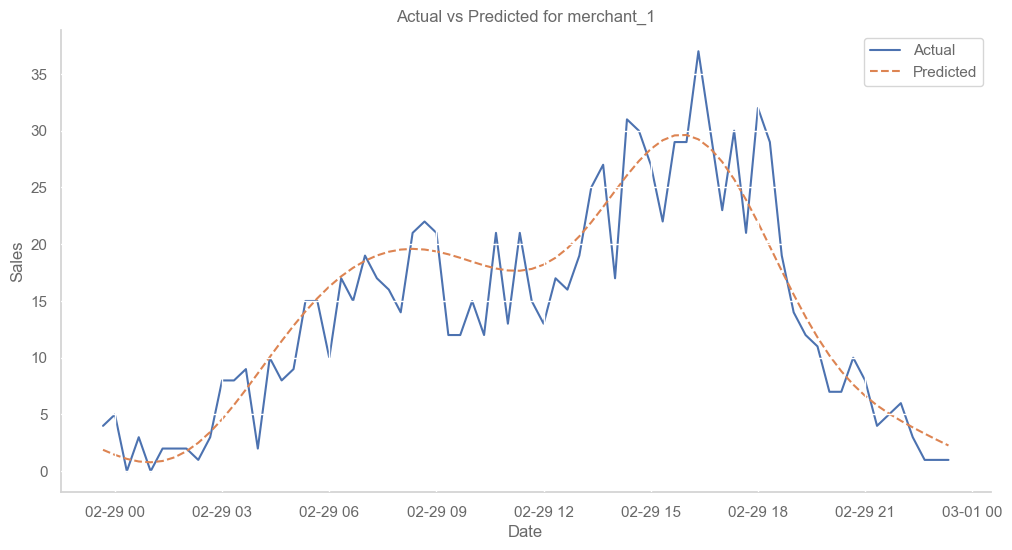

19:18:15 - cmdstanpy - INFO - Chain [1] start processing
19:18:15 - cmdstanpy - INFO - Chain [1] done processing


merchant_10 - RMSE: 3.90, MAE: 2.88


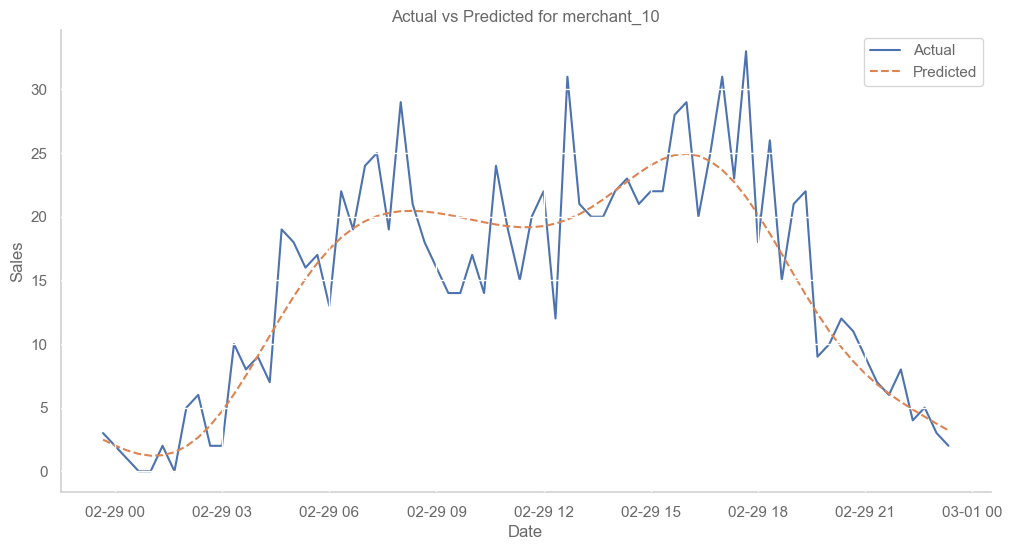

19:18:18 - cmdstanpy - INFO - Chain [1] start processing
19:18:18 - cmdstanpy - INFO - Chain [1] done processing


merchant_11 - RMSE: 2.79, MAE: 2.10


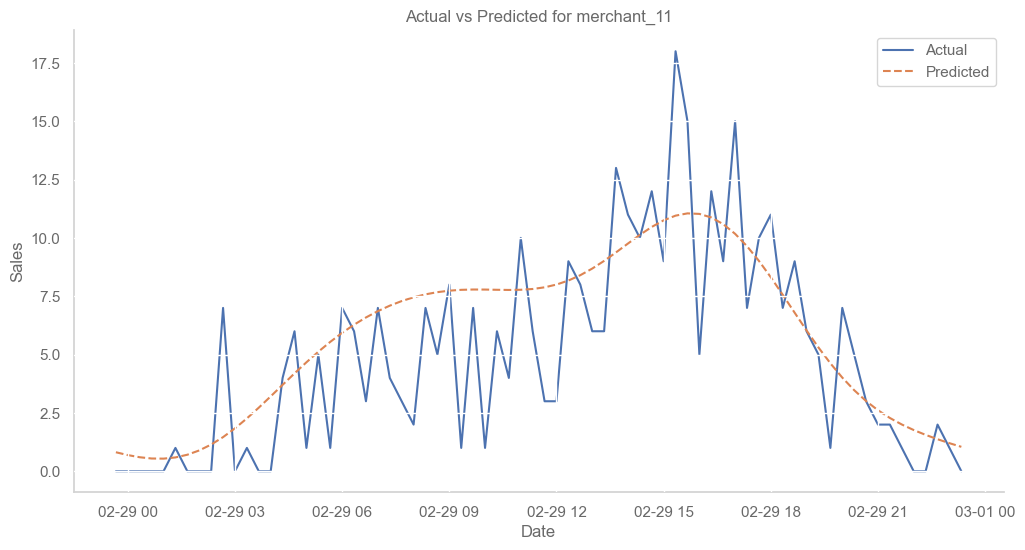

19:18:21 - cmdstanpy - INFO - Chain [1] start processing
19:18:24 - cmdstanpy - INFO - Chain [1] done processing


merchant_12 - RMSE: 2.71, MAE: 2.09


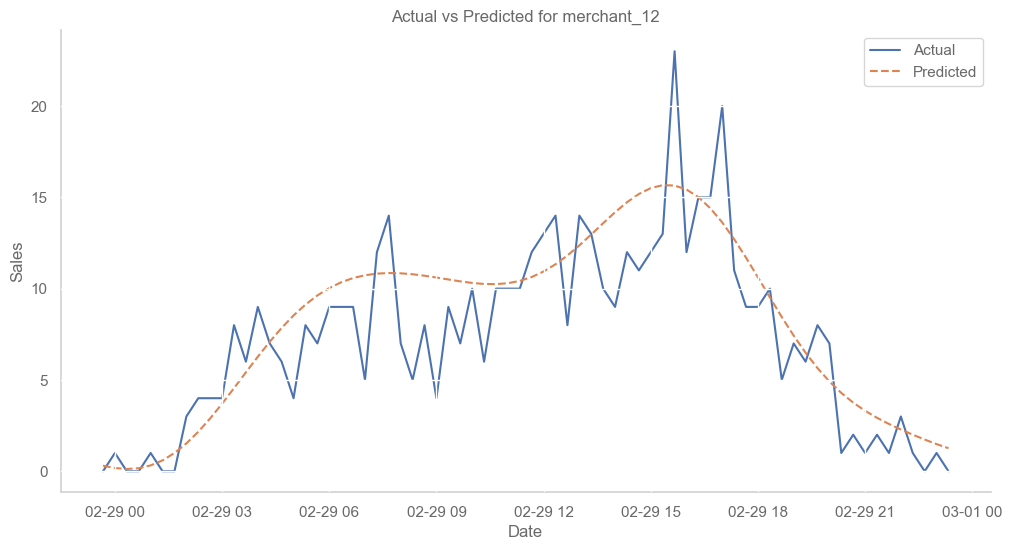

19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing


merchant_2 - RMSE: 4.25, MAE: 3.19


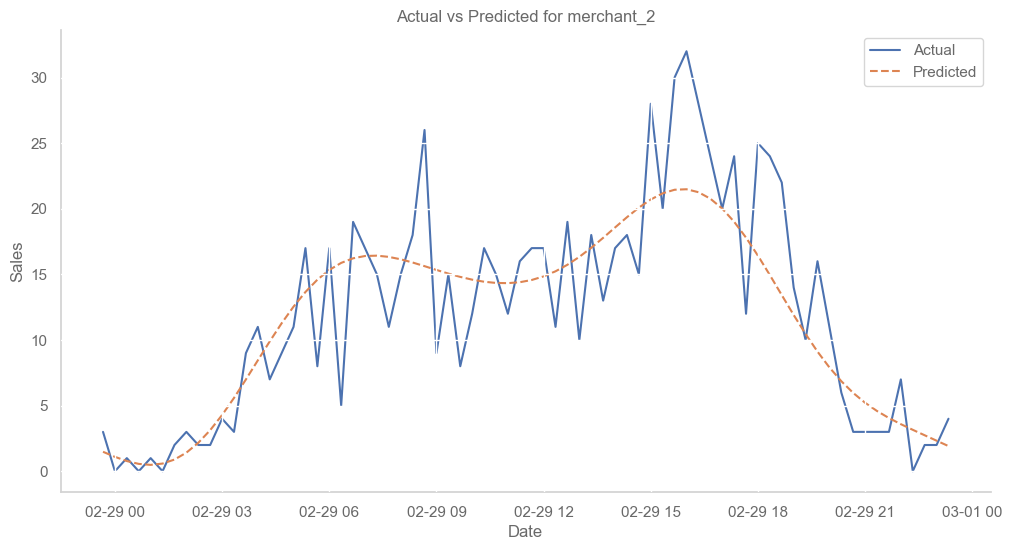

19:18:29 - cmdstanpy - INFO - Chain [1] start processing
19:18:29 - cmdstanpy - INFO - Chain [1] done processing


merchant_3 - RMSE: 2.96, MAE: 2.21


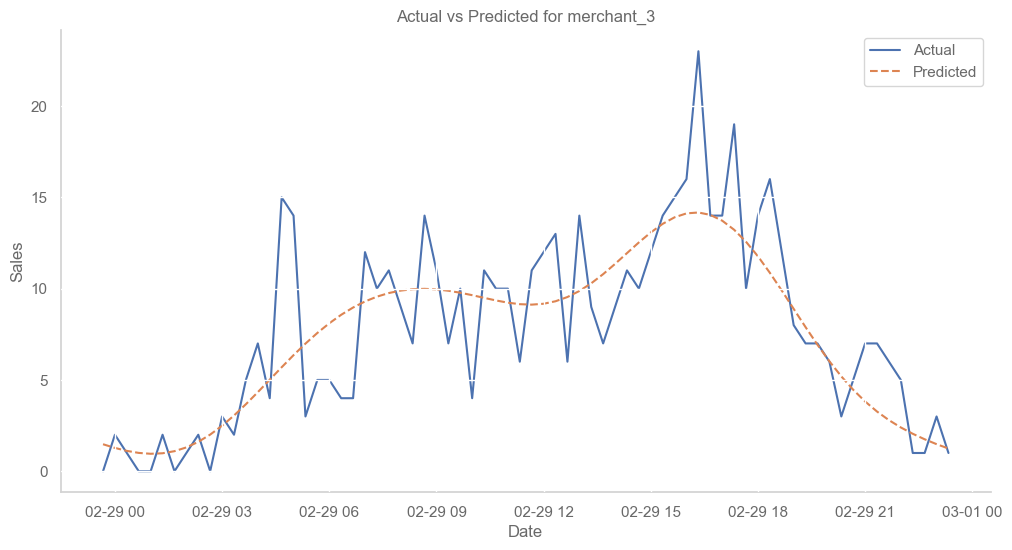

19:18:32 - cmdstanpy - INFO - Chain [1] start processing
19:18:32 - cmdstanpy - INFO - Chain [1] done processing


merchant_4 - RMSE: 4.46, MAE: 3.29


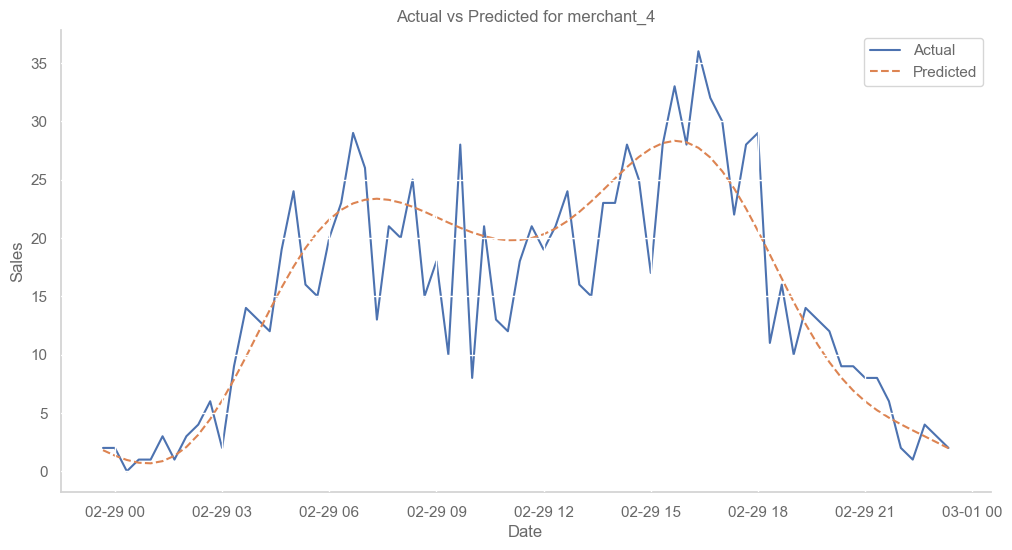

19:18:35 - cmdstanpy - INFO - Chain [1] start processing
19:18:35 - cmdstanpy - INFO - Chain [1] done processing


merchant_5 - RMSE: 4.93, MAE: 3.74


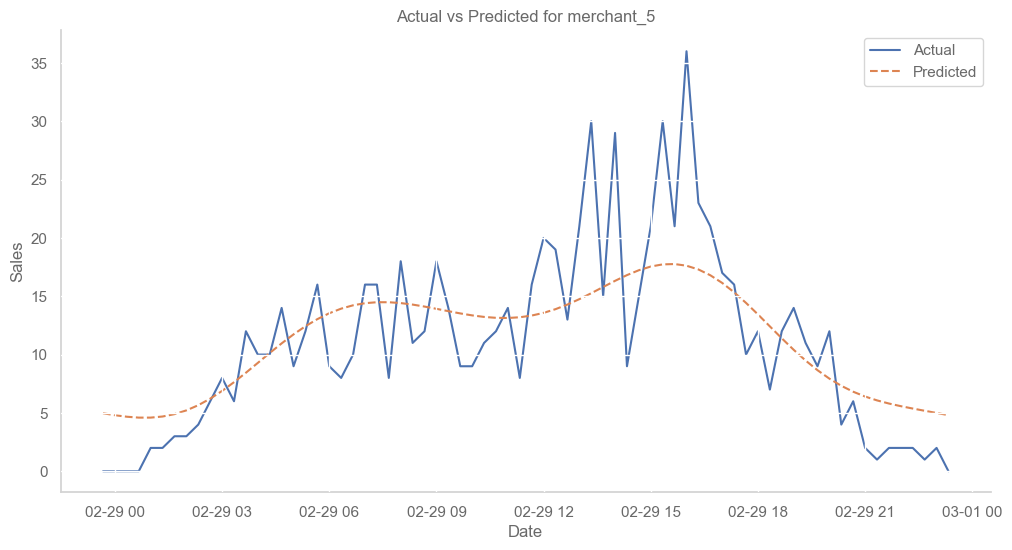

19:18:38 - cmdstanpy - INFO - Chain [1] start processing
19:18:38 - cmdstanpy - INFO - Chain [1] done processing


merchant_6 - RMSE: 3.34, MAE: 2.79


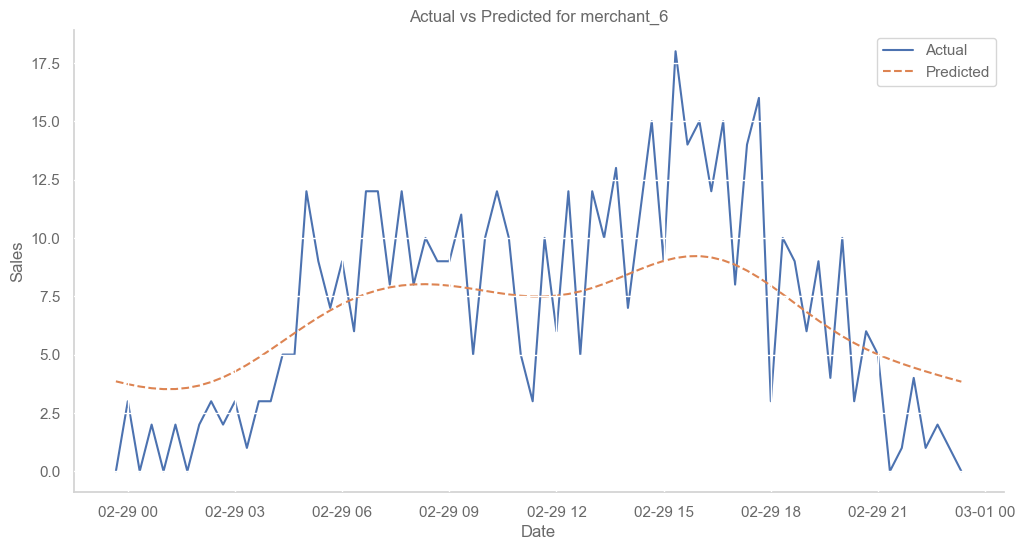

19:18:41 - cmdstanpy - INFO - Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing


merchant_7 - RMSE: 2.87, MAE: 2.27


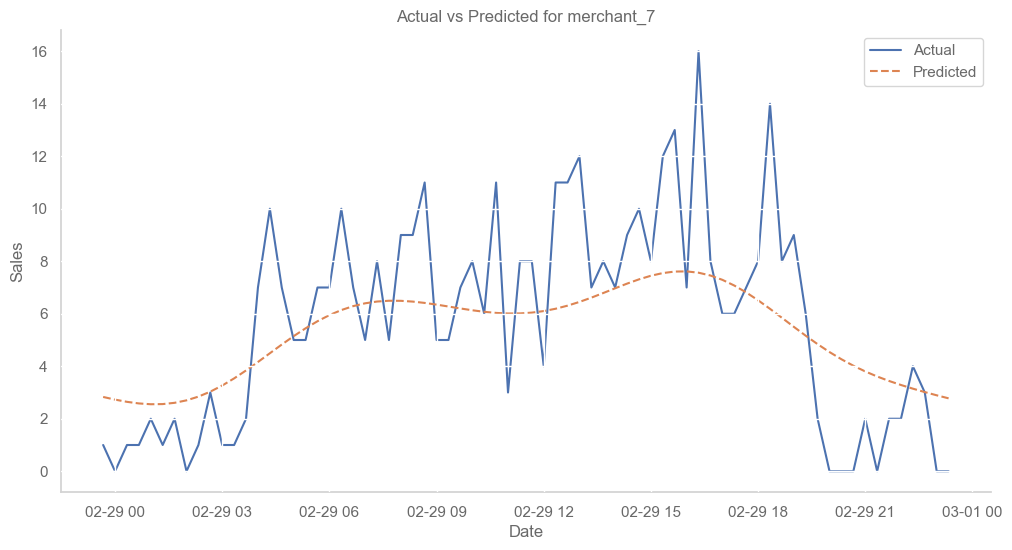

19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing


merchant_8 - RMSE: 3.29, MAE: 2.71


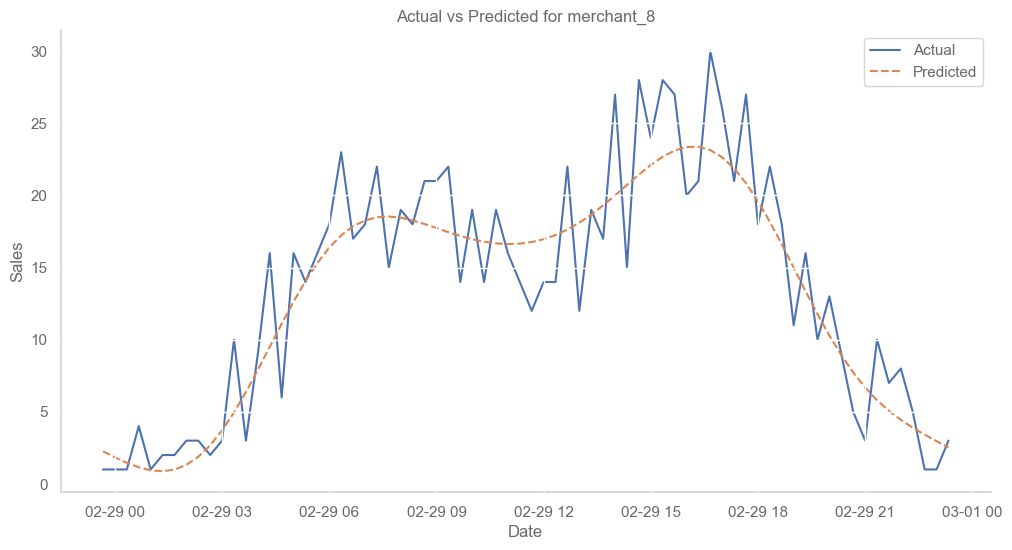

19:18:47 - cmdstanpy - INFO - Chain [1] start processing
19:18:47 - cmdstanpy - INFO - Chain [1] done processing


merchant_9 - RMSE: 3.79, MAE: 2.82


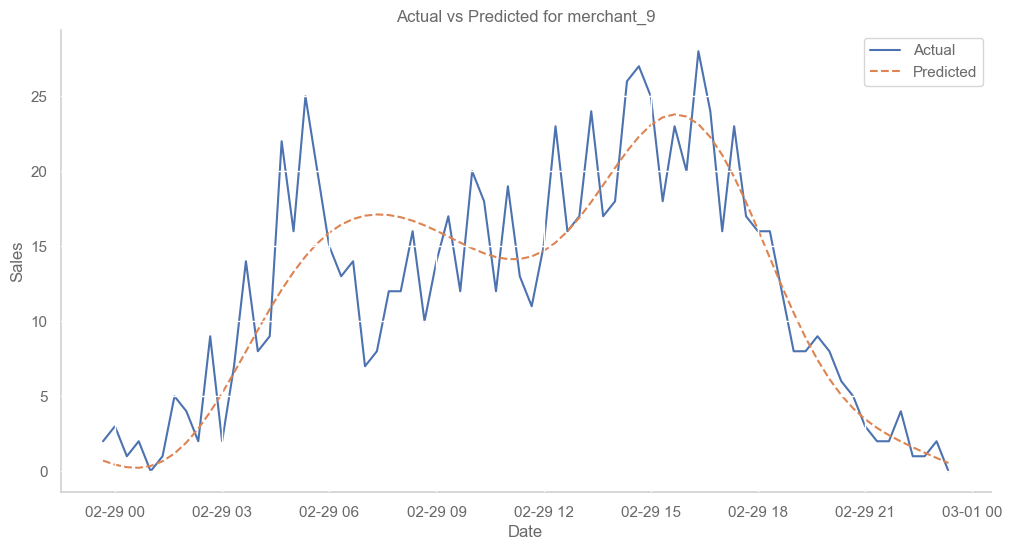

In [27]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_orders_df.columns:
    
    #formatting
    df_copy = total_orders_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    #print(feature,mape(predicted_df['y'],predicted_df['yhat']))
    # Calculate RMSE and MAE
    rmse = np.sqrt(np.mean((predicted_df['y'] - predicted_df['yhat'])**2))
    mae = np.mean(np.abs(predicted_df['y'] - predicted_df['yhat']))

    print(f"{feature} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_df['ds'], predicted_df['y'], label='Actual')
    plt.plot(predicted_df['ds'], predicted_df['yhat'], label='Predicted', linestyle='--')
    plt.title(f'Actual vs Predicted for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

### FINAL FORECASTING

In [ ]:
prediction_days = 1
forecast_start_date = max(total_orders_df.index)

In [ ]:
total_orders_df.columns

Index(['merchant_1', 'merchant_10', 'merchant_2', 'merchant_3', 'merchant_4',
       'merchant_5', 'merchant_6', 'merchant_7', 'merchant_8', 'merchant_9'],
      dtype='object', name='segment')

In [ ]:
# #PROPHET MODEL

# forecasted_dfs = []

# for feature in total_sales_df.columns[:5]:
    
#     #formatting
#     df_copy = total_sales_df[feature].copy().reset_index()
#     df_copy.columns = ['ds','y']
#     df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

#     df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
#     df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
#     #finding the right params_dict for this category
#     params_dict = dicts[feature]
    
#     #model
#     m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
#                 seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
#                 seasonality_mode = 'multiplicative',
#                 holidays=holiday
#                  )
    
#     m.fit(df_copy_)

#     future = m.make_future_dataframe(periods=prediction_days * 72, freq='20min')
#     fcst_prophet_train = m.predict(future)
    
#     fig1 = m.plot(fcst_prophet_train)
#     fig2 = m.plot_components(fcst_prophet_train)

#     forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
#     forecasted_dfs.append(forecasted_df)

In [ ]:
#fcst_prophet_train